In [1]:
# standard python packages
import os, sys
from os.path import abspath, dirname, basename
from glob import glob
import numpy as np
import pandas as pd
import warnings
import joblib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns   
sns.set_style("whitegrid")
import dcor
from copy import copy, deepcopy

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# import toybrains
TOUYBRAINS_REPO = os.path.abspath("../../")
if TOUYBRAINS_REPO not in sys.path: sys.path.append(TOUYBRAINS_REPO)

from utils.DLutils import *
from utils.vizutils import *

In [3]:
DEEPREPVIZ_BACKEND = abspath( "../../../Deep-confound-control-v2/application/backend/deep_confound_control/core/")
assert os.path.isdir(DEEPREPVIZ_BACKEND) and os.path.exists(DEEPREPVIZ_BACKEND+'/DeepRepVizBackend.py'), f"No DeepRepViz repository found in {DEEPREPVIZ_BACKEND}. Add the correct relative path to the backend to the 'DEEPREPVIZ_BACKEND' global variable."
if DEEPREPVIZ_BACKEND not in sys.path:
    sys.path.append(DEEPREPVIZ_BACKEND)
from DeepRepVizBackend import DeepRepVizBackend

In [4]:
N_SAMPLES = 5000
EXP_NAME = 'lblmidr-consite'

In [261]:
SHOW_ACCURACIES = False
SHOW_DATASETS_DISTS = False
SHOW_DATASETS_IMAGES = False
SHOW_DATASETS_CORRS = False

RUN_PCA=False
RUN_ICA=False
RUN_LDA=False
RUN_CCA=False
RUN_ican_sim=True
RUN_ican=True

## Compute all metrics (DL-act-based $A_{conf}$ scores)

```bash
! python3 run-deeprepvizbackend.py
```
with correct configurations set inside the `run-deeprepvizbackend.py` file

## Load Logdirs using DRV

In [6]:

def lognames_sortrank(logname):
    cy = int(logname.split('cy')[-1].split('-')[0])
    cX = int(logname.split('cX')[-1].split('-')[0])
    yX = int(logname.split('yX')[-1].split('_')[0])
    # sort the index by 100 times (X<-y) signal + 0.5 times (X<-c * c->y) signal
    rank = 100*yX + cX*cy/100
    return rank

In [7]:
# select the model runs for which we want to compare the results
cy = '*'
cX = '*'
yX = '*'
exclude = ['debug']
def check_excludes(str, excludes_list):
    for exclude in excludes_list:
        if exclude in str:
            return False
    return True

logdirs = sorted(
    list(set([
        (dirname(dirname(log))) for log in glob(f"log/toybrains*_cy{cy}-cX{cX}-yX{yX}*/*/deeprepvizlog") if check_excludes(log, exclude)]
        )))

print("Collected n={} model logs:".format(len(logdirs)))
# drop log folders that have not been reduced to 3D representations
# logdirs = [logdir for logdir in logdirs if len(glob(f"{logdir}/*/deeprepvizlog/DeepRepViz-v1*"))==len(glob(f"{logdir}/*/deeprepvizlog/"))]
# print("after dropping incomplete logs n={} logs are still remaining".format(len(logdirs)))
    
logdirs = sorted(logdirs, key=lambda l: lognames_sortrank(l))
print("Final list of selected logdirs:")
logdirs

Collected n=75 model logs:
Final list of selected logdirs:


['log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f003',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f064',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f256',
 'log/toybrains_n5000_lblmidr-consite_cy025-cX025-yX000_SimpleCNN_c1-f003',
 'log/toybrains_n5000_lblmidr-consite_cy025-cX025-yX000_SimpleCNN_c1-f064',
 'log/toybrains_n5000_lblmidr-consite_cy025-cX025-yX000_SimpleCNN_c1-f256',
 'log/toybrains_n5000_lblmidr-consite_cy050-cX050-yX000_SimpleCNN_c1-f003',
 'log/toybrains_n5000_lblmidr-consite_cy050-cX050-yX000_SimpleCNN_c1-f064',
 'log/toybrains_n5000_lblmidr-consite_cy050-cX050-yX000_SimpleCNN_c1-f256',
 'log/toybrains_n5000_lblmidr-consite_cy075-cX075-yX000_SimpleCNN_c1-f003',
 'log/toybrains_n5000_lblmidr-consite_cy075-cX075-yX000_SimpleCNN_c1-f064',
 'log/toybrains_n5000_lblmidr-consite_cy075-cX075-yX000_SimpleCNN_c1-f256',
 'log/toybrains_n5000_lblmidr-consite_cy100-cX100-yX000_SimpleCNN_c1-f003',
 'log/toybra

In [8]:
# parallelize the loading of the logs
def process_drvlogdir(deeprepvizlogdir, rename_datasets=True, verbose=1):

    if verbose>=1: print("loading from:", deeprepvizlogdir)

    iter_version = basename(dirname(deeprepvizlogdir))
    if verbose>=1: print("loading run version:", iter_version)
    
    # find the attribute table of the dataset
    dataset_name = '_'.join(deeprepvizlogdir.lstrip('/').split('/')[1].split('_')[:-2]) # drop the model name to get the dataset name
    df_attrs = pd.read_csv(f'dataset/{dataset_name}/{dataset_name}.csv') 

    drv = DeepRepVizBackend(conf_table=df_attrs, 
                                    ID_col='subjectID', label_col='lbl_lesion', 
                                    best_ckpt_by="loss_test")
    drv.load_log(deeprepvizlogdir)


    log = drv.deeprepvizlogs[deeprepvizlogdir]
    ckpt_idx = log['best_ckpt_idx']
    ckptname, log_ckpt = log['checkpoints'][ckpt_idx]
    logdirname = deeprepvizlogdir.split('/')[-3]
    dataset = logdirname.split('_')[3]
    model_name = logdirname.replace(dataset, '').split('__')[-1]


    if verbose>=2:
        print(f"{'='*100}\n {model_name} :: \n\t setting: {dataset} ")
        print(f"\t at ckpt: {ckptname} (idx={ckpt_idx}) \n\t ckpt contains: {list(log_ckpt.keys())}")
        print("\t Model accuracy : {}".format({k:f'{v*100:.2f}%' for k,v in log_ckpt['metrics'].items()})) 
        
    # calculate the correlation between y and conf attributes in X and true attributes in X
    # get the numericalized and cleaned version of the attributes table
    df_attrs = drv.df_conf
    # reorder to match the IDs of the model results and the confound table
    df_attrs = df_attrs.loc[log['IDs']]
    Aconf = int(df_attrs['brain-int_fill'].corr(df_attrs['lbl_lesion'], method='spearman')**2 * 100)
    Atrue = int(df_attrs['shape-midr_vol-rad'].corr(df_attrs['lbl_lesion'], method='spearman')**2 * 100)
    if rename_datasets:
        prev_name = dataset
        def round_to(x, base=5): return base * round(x/base)
        dataset = f"True={round_to(Atrue, base=5):03d}% Conf={round_to(Aconf, base=5):03d}%"
        if verbose>=1: print(f"Renamed dataset from {prev_name} to {dataset}")
        
    result = {("Model",k): v for k,v in log_ckpt['metrics'].items()}
    # if 'act_metrics' not in log_ckpt:
    #     print(f"[WARN] Metrics not computed for {logdirname}/{iter_version} at ckpt={ckptname} (idx={ckpt_idx}). Not aggregating metrics...")
        
    # else:
    #     for metric_name, metric_scores in log_ckpt['act_metrics'].items():
    #         if verbose>=2: print(f"\t {'-'*10} \t Metric = {metric_name} \t {'-'*30}")
    #         for key in ['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']:
    #             if verbose: print("\t {} \t=\t {:.4f}".format(key, metric_scores[key]))
    #             result.update({(key, metric_name): metric_scores[key]})

   

    ### (2) load the activation at the best checkpoints of the given model
    act = log['checkpoints'][ckpt_idx][1]['acts']
    test_acc = log['checkpoints'][ckpt_idx][1]['metrics']['BAC_test']
    best_ckpt_tensors = {
        'best_ckpt_idx': log['best_ckpt_idx'],
        'IDs': log['IDs'],
        'y': log['labels'].astype(float),
        'act': act,
        'y_pred_weights': log['checkpoints'][log['best_ckpt_idx']][1]['weights_0'], 
        'y_pred_biases': log['checkpoints'][log['best_ckpt_idx']][1]['biases_0'],
        # also save other generic dataset sepecific information
        'y_pred': log['checkpoints'][log['best_ckpt_idx']][1]['preds_0'].astype(float),
        'test_acc': test_acc,
        'Atrue': Atrue,
        'Aconf': Aconf

        
    }
    if verbose>=1: print(f"activation loaded with shape {act.shape}")

    return (dataset, model_name, iter_version, best_ckpt_tensors), result


#################################################################################################################


# collect the DeepRepViz backend results in a dict
def collect_deeprepviz_results(logdirs, rename_datasets=True, verbose=1, n_jobs=-1):

    # for each logdir extract the list of all runs
    logdirs_runs = []
    for logdir in logdirs:
        logdirs_runs.extend(sorted(glob(f"{logdir}/*/deeprepvizlog")))

    all_results_drvs = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(process_drvlogdir)(drvlogdir, 
                                          rename_datasets=rename_datasets,
                                          verbose=verbose) for drvlogdir in tqdm(logdirs_runs))
    
    if len(all_results_drvs)==0:
        print("[ERROR] No results were loaded. Exiting...")
        return None

    # sort them by the dataset name first by yX
    all_results_drvs = sorted(all_results_drvs, key= lambda logs: lognames_sortrank(logs[0][0]))

    ### combine all the results into one dataframe
    all_results = {(d,m,v): result_row for (d,m,v,_),result_row in all_results_drvs}
    
    df_results = pd.DataFrame.from_dict(all_results, orient='index')
    df_results.index = df_results.index.set_names(['dataset', 'model_name', 'trial'])
    # sort the rows: by dataset then within it by trial
    df_results = df_results.sort_index(level='trial').sort_index(level=0,
                                                        key=np.vectorize(lognames_sortrank)) #, 'dataset' )

    # reorder the columns: multi-index to first have the model name and then the metric name
    df_results = df_results.sort_index(axis='columns', level=[0,1])
    
    ### collect the tensors into another list 
    logs = [(d,m,v, tensors) for (d,m,v, tensors), _ in all_results_drvs]
    
    return df_results, logs

In [9]:
df_results, logs = collect_deeprepviz_results(logdirs, rename_datasets=False, verbose=0, n_jobs=-1)

  0%|          | 0/225 [00:00<?, ?it/s]

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested

In [10]:
unique_models = sorted(list(set([model for _, model, _, _ in logs])))
unique_datasets = sorted(list(set([dataset for dataset, _, _, _ in logs])), key=lognames_sortrank)
# unique_datasets

## Show Accuracies

In [11]:
if SHOW_ACCURACIES:
    print("loaded {} rows with {} models, {} unique datasets per model with upto {} trials per dataset.".format(len(df_results), 
                                            (df_results.index.get_level_values('model_name').nunique()), 
                                            (df_results.index.get_level_values('dataset').nunique()), 
                                            (df_results.index.get_level_values('trial').nunique())))

    # show the table
    # display(df_results.style.bar(vmin=0, vmax=1))

In [12]:
df_results

Model                   \
                                             BAC_test BAC_test-no-conf   
dataset           model_name        trial                                
cy000-cX000-yX000 SimpleCNN_c1-f003 trial_0  0.543863         0.503230   
                                    trial_1  0.521730         0.498008   
                                    trial_2  0.524726         0.521978   
                  SimpleCNN_c1-f064 trial_0  0.490419         0.502238   
                                    trial_1  0.503580         0.512761   
...                                               ...              ...   
cy100-cX100-yX100 SimpleCNN_c1-f064 trial_1  1.000000         0.519761   
                                    trial_2  1.000000         0.523720   
                  SimpleCNN_c1-f256 trial_0  1.000000         0.517487   
                                    trial_1  1.000000         0.521665   
                                    trial_2  1.000000         0.511378   

                                                                        \
                                            BAC_test-no-true BAC_train   
dataset           model_name        trial                                
cy000-cX000-yX000 SimpleCNN_c1-f003 trial_0         0.503230  0.527026   
                                    trial_1         0.498008  0.525048   
                                    trial_2         0.521978  0.523076   
                  SimpleCNN_c1-f064 trial_0         0.502238  0.526788   
                                    trial_1         0.512761  0.507020   
...                                                      ...       ...   
cy100-cX100-yX100 SimpleCNN_c1-f064 trial_1         1.000000  1.000000   
                                    trial_2         1.000000  1.000000   
                  SimpleCNN_c1-f256 trial_0         1.000000  1.000000   
                                    trial_1         1.000000  1.000000   
                                    trial_2         1.000000  1.000000   

                                                                 \
                                              BAC_val   D2_test   
dataset           model_name        trial                         
cy000-cX000-yX000 SimpleCNN_c1-f003 trial_0  0.493998 -0.002485   
                                    trial_1  0.507791 -0.005452   
                                    trial_2  0.513611 -0.002815   
                  SimpleCNN_c1-f064 trial_0  0.502687 -0.009820   
                                    trial_1  0.518800 -0.006081   
...                                               ...       ...   
cy100-cX100-yX100 SimpleCNN_c1-f064 trial_1  1.000000  0.999430   
                                    trial_2  1.000000  1.000000   
                  SimpleCNN_c1-f256 trial_0  1.000000  1.000000   
                                    trial_1  1.000000  1.000000   
                                    trial_2  0.999311  1.000000   

                                                                             \
                                            D2_test-no-conf D2_test-no-true   
dataset           model_name        trial                                     
cy000-cX000-yX000 SimpleCNN_c1-f003 trial_0       -0.006775       -0.006775   
                                    trial_1       -0.004356       -0.004356   
                                    trial_2       -0.006233       -0.006233   
                  SimpleCNN_c1-f064 trial_0       -0.007207       -0.007207   
                                    trial_1       -0.010613       -0.010613   
...                                                     ...             ...   
cy100-cX100-yX100 SimpleCNN_c1-f064 trial_1       -9.066239        1.000000   
                                    trial_2       -8.785521        1.000000   
                  SimpleCNN_c1-f256 trial_0       -9.752451        1.000000   
                                    trial_1       -9.842165        1.000000   
        

See average values across trials

In [13]:
if SHOW_ACCURACIES:
    # display the average performances across trials for all datasets and all models
    df_results_plot = df_results.reset_index().groupby(['dataset'])
    display(df_results_plot.mean(numeric_only=True).style.bar(vmin=0, vmax=1))

    # Plot how the BAC_test scores change as we change the mutual information between X <- y and X <- c -> y  different levels of confound and true signal
    df_results_plot = df_results.droplevel(0,'columns').reset_index()
    df_results_plot['yX'] = df_results_plot['dataset'].str.extract(r'yX(\d+)').astype(int)
    df_results_plot['cX'] = df_results_plot['dataset'].str.extract(r'cX(\d+)').astype(int)
    df_results_plot['cy'] = df_results_plot['dataset'].str.extract(r'cy(\d+)').astype(int)
    df_results_plot['cXy'] = (df_results_plot['cX'] * df_results_plot['cy'])**0.5
    sns.pointplot(df_results_plot, x='yX', y='BAC_test', hue='cXy', palette='viridis', alpha=.2, legend=False)
    sns.stripplot(df_results_plot, x='yX', y='BAC_test', hue='cXy', palette='viridis', legend=True)
    plt.show()

### Plot the results

In [14]:
def plot_deeprepviz_results(df_results, 
                            filter = '.*',
                            norm_metrics = '', #'dcor|mi|con|r2',
                            model_name_filter='.*',
                            hue_order=None,
                            ylim = None):
    df = df_results.copy()
    df = df.sort_index(level='trial').sort_index(level=0, key=np.vectorize(lognames_sortrank))
    # flatten the multi-index columns
    df.columns = [' | '.join(col[::-1]).strip() for col in df.columns.values]

    original_cols = list(df.columns)
    # drop the loss columns
    df = df.filter(regex='^(?!.*loss.*)')
    # drop the costeta columns
    df = df.filter(regex='^(?!.*costeta)')
    # apply other user-provided column filters
    df = df.filter(regex=filter)
    assert len(df.columns) != 0, f"No columns remained after applying the filter: {filter} out of the orignal:\n{original_cols}"

    # drop the loss
    # df = df.drop(columns=[('model_name', ''),('trial', ''), *loss_cols])
    # sort the final columns alphabetically
    df = df.reindex(sorted(df.columns), axis='columns')
    # drop the indexes 'model_name' and 'trial' and only keep the 'data_setting' as index
    df = df.reset_index(level=['model_name', 'trial'])
    # apply the model type selection filter
    df = df[df['model_name'].str.match(model_name_filter)]

    for feas, dfi in df.groupby('model_name'):

        dfi = dfi.drop(columns=['model_name', 'trial'])
        # normalize the metrics requested
        if norm_metrics != '':
            metric_cols = dfi.columns.str.contains(norm_metrics)
            dfi.loc[:, metric_cols] = dfi.loc[:, metric_cols].apply(
            lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis=1)
    
        # plot the results
        fig, ax = plt.subplots(figsize=(12, 4))
        g = sns.lineplot(dfi, err_style="bars", ax=ax, dashes=False, 
                         hue_order=hue_order) 
        sns.move_legend(g, loc="upper center", bbox_to_anchor=(0.5, 1.5), ncols=4)
        
        ax.set_title(f"DL model settings: {feas.split('_')}")
        if ylim is not None or norm_metrics!='': ax.set_ylim(ylim)

        # on the x-axis ticks show the total correlation X<-y and the total X<-c->y
        # new_xticklabels = ax.get_xticklabels()
        new_xticklabels = []
        majorticks = []
        last_Xy = -1
        last_Xcy = -1
        for lbl in ax.get_xticklabels():
            cy, cX, yX  = lbl.get_text().split('-')
            cy = int(cy[-3:])
            cX = int(cX[-3:])
            yX = int(yX[-3:])
            total_Xy = yX
            total_Xcy = (cX*cy)**(1/2)                

            if total_Xy != last_Xy:
                new_xticklabels.append(f'True={total_Xy:3.0f}%      Conf={total_Xcy:3.0f}%')
                last_Xy = total_Xy
                # add a major tick label every time the total_Xy changes
                majorticks.append(lbl.get_position()[0]-1)
            else:
                new_xticklabels.append(f'Conf={total_Xcy:3.0f}%')
        
        ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)
        # vertical lines to show transition of X<-c->y
        for x_line in majorticks:
            if x_line>0:
                ax.vlines(x_line, ax.get_ylim()[-1], -0.1, color='grey', ls='--', lw=1,
                        clip_on=False, transform=ax.get_xaxis_transform())
        # ax.set_xlim(-0.1, majorticks[-1]+1)

        ax.set_xlabel(r'Increasing confound signal [$X \leftarrow c \to y$]   &   True signal  [$X \leftarrow y$] ', fontsize=15)
    
        plt.show()


#############################################################################################################
if SHOW_ACCURACIES:
    plot_deeprepviz_results(df_results, filter='BAC_test.*Model.*',  
                            model_name_filter='.*',
                            hue_order=['BAC_test | Model', 'BAC_test-no-true | Model', 'BAC_test-no-conf | Model'],
                            norm_metrics='')

## New metrics: CCA / PCA / ICA

In [15]:
# logdir_runs =([l for logdir in logdirs for l in glob(f"{logdir}/*/deeprepvizlog")])
# logdir_runs = sorted(logdir_runs, key=lambda l: lognames_sortrank(l.split('/')[-3]))
# logdir_runs

### Load activations $H^{(l-1)}$ for all trials

#### Datasets distributions

In [16]:
from utils.vizutils import plot_col_dists, plot_col_counts, show_images

if SHOW_DATASETS_IMAGES or SHOW_DATASETS_DISTS or SHOW_DATASETS_CORRS:

    for dataset_cy_cx_yx in unique_datasets:
        
        dataset_log = 'Dataset: '+ dataset_cy_cx_yx
        print('--'*80, '\n', dataset_log)
        dataset_name = f'dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset_cy_cx_yx}'
        df = pd.read_csv(f'{dataset_name}/{os.path.basename(dataset_name)}.csv') 
        # drop the volumes(_vol) as radius (_rad) already captures this info
        df = df.drop(columns=df.columns[df.columns.str.contains('vol') & ~(df.columns.str.contains('rad'))])

        ### (1) show the image attributes distributions
        cov_cols = df.filter(regex='^(cov_|lbl_)').columns
        attr_cols = df.filter(regex='^(?!(cov_|lbl_)).+').columns
        if SHOW_DATASETS_DISTS:
            plot_col_dists(df, 
                        attr_cols=attr_cols, 
                        cov_cols=cov_cols, 
                        title=f"Distributions of the image attributes after sampling")
            plt.show()

            ### (2) show the label and confounder distributions
            plot_col_counts(df[cov_cols], title="Label & confound dist.:")
            plt.show()

        ### (3) show the correlation between the conf and labels
        if SHOW_DATASETS_CORRS:
            drv = DeepRepVizBackend(conf_table=df, 
                                ID_col='subjectID', label_col='lbl_lesion', 
                                best_ckpt_by="test_loss")
            # colormap diverging from black instead of white
            hue_neg, hue_pos = 250, 15
            cmap = sns.diverging_palette(hue_neg, hue_pos, center="dark", as_cmap=True)

            corr = drv.df_conf.corr()
            # mask out the upper triangle
            mask = np.zeros_like(corr, dtype=bool)
            mask[np.triu_indices_from(mask)] = True
            # vals with very low correlation (|corr|  < 0.01) are masked out too
            mask[(np.abs(corr) < 0.025)] |= True
            # set the masked values to nan so that it will be not displayed using .format(na_rep='')
            corr[mask] = np.nan
            display(corr.style
                        .background_gradient(cmap='copper', axis=None, vmin=0, vmax=1)
                        .format(precision=2, na_rep=''))

        ### (3) show sample images for different combinations of the conf and label states
        if SHOW_DATASETS_IMAGES:
            n_imgs_per_row = 15
            # show 4 rows of images with different combinations of covariate and label states
            # df = pd.read_csv(f'{dataset}/toybrains_n{N_SAMPLES}_{basefilename}_cy{cy}-cX{cX}-yX{yX}.csv')
            for (lbl, cov), dfi in df.groupby(['lbl_lesion', 'cov_site']):
                # sample n_imgs_per_row 
                samples = dfi.sample(n_imgs_per_row, replace=False, random_state=None).index.values
                img_files = [f"{dataset_name}/images/{s:05}.jpg" for s in samples]
                # print(lbl, cov, img_files)
                show_images(img_files=img_files,
                            n_cols=n_imgs_per_row, n_rows=1,
                            title=f"{dataset_log}      |      lbl_lesion={lbl}      |       cov_site={cov}      |")
                plt.show()

### $\frac{dCor(\hat{y},c)}{dCor(y,c)}$

In [17]:
def compute_dcor_sq(X, y):
    if len(X.shape)>1: 
        y = y.reshape(-1,1)
    assert X.shape[0]==y.shape[0], f"the shape of the activations and covariates should be (N, D) and (N, 1)\
 respectively but they are {X.shape} and {y.shape} respectively"
    dcor_score = float(dcor.distance_correlation_sqr(X, y))
    return dcor_score**2

In [18]:
# N_COMPONENTS = 3 


# for dataset in unique_datasets:

#     logs_subset = [log for log in logs if (log[0]==dataset)]
#     if len(logs_subset)==0: continue

#     fig, axes = plt.subplots(1, len(logs_subset), 
#                             sharex=True, sharey=True, 
#                             figsize=(2+3*len(logs_subset), 6))
#     axes = axes.flatten()
#     fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

#     for ax, (dataset, model_name, run, log) in zip(axes, logs_subset):
#         # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

#         # (1) load the confounds table
#         df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
#         # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

#         # make the table values numerical using the DeepRepVizBackend
#         drv = DeepRepVizBackend(conf_table=df_attrs, 
#                                 ID_col='subjectID', label_col='lbl_lesion', 
#                                 best_ckpt_by="test_loss")
#         df_attrs = drv.df_conf
#         # reorder to match the IDs of the model results and the confound table
#         df_attrs = df_attrs.loc[log['IDs']]

#         # (2) select the subset of covariates to compute the metrics
#         conf_subset =  df_attrs.columns  # ['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
        
#         # (3) Compute the metric and populate it in a table
#         df_scores = pd.DataFrame(index=['y_true','y_pred'], columns=conf_subset)

#         assert np.all(log['IDs'] == df_attrs.index.values), "IDs do not match between the confound table and the model results."
#         for y_name, y in [('y_true', log['y']), ('y_pred', log['y_pred']>0.5)]:
#             for conf in conf_subset:
#                 conf_var = df_attrs[conf].values
#                 df_scores.at[y_name, conf] = compute_dcor_sq(y.astype(float), conf_var.astype(float))

#         df_scores.T.plot.barh(ax=ax, width=0.8)
#         ax.set_title(f"Model: {model_name} \nRun: {run}    Test BAC={log['test_acc']*100:.0f}%", fontsize=10)
#         ax.legend(loc='center right', prop={'size': 6})
        
#         # if xlim is very low then set it to atleast [0,0.5]
#         if ax.get_xlim()[1] < 0.5:
#             ax.set_xlim(0, 0.5)
#         else:
#             ax.set_xlim(0, 1.)

#     plt.tight_layout()
#     plt.show()

### PCA ($H^{(l-1)}, c$)

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def compute_pca(X, n_components=0.9):
    # standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # apply PCA and print the list of PC components that explain 90% of the variance
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca, pca

In [20]:
if RUN_PCA:
    N_COMPONENTS = 3 


    for dataset in unique_datasets:

        logs_subset = [log for log in logs if (log[0]==dataset)]
        if len(logs_subset)==0: continue

        fig, axes = plt.subplots(1, len(logs_subset), 
                                sharex=True, sharey=True, 
                                figsize=(2+3*len(logs_subset), 6))
        axes = axes.flatten()
        fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

        for ax, (dataset, model_name, run, log) in zip(axes, logs_subset):
            # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

            # (1) load the confounds table
            df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
            # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

            # make the table values numerical using the DeepRepVizBackend
            drv = DeepRepVizBackend(conf_table=df_attrs, 
                                    ID_col='subjectID', label_col='lbl_lesion', 
                                    best_ckpt_by="test_loss")
            # reorder to match the IDs of the model results and the confound table
            df_attrs = drv.df_conf
            df_attrs = df_attrs.loc[log['IDs']]
            
            # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")
            X_pca, pca = compute_pca(log['act'], n_components=N_COMPONENTS)
            # for 5 variables in the metadata table compute the correlation with the top PCs
            conf_subset =  df_attrs.columns #['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
            df_scores = pd.DataFrame(index=[f"PC{i}" for i in range(N_COMPONENTS)], columns=conf_subset)

            for i in range(N_COMPONENTS):
                for conf in conf_subset:
                    conf_var = df_attrs[conf][log['IDs']]
                    df_scores.at[f"PC{i}", conf] = compute_dcor_sq(X_pca[:,i], conf_var.astype(float))

            # add the explained variance of each PC in the legend info
            def append_r2(pc):
                i = int(pc.replace('PC', ''))
                return "PC{} ($R^2={:.0f}$%)".format(i, pca.explained_variance_ratio_[i]*100)
            df_scores.index = pd.Series(df_scores.index).apply(append_r2)
            # print("Number of components with 90% variance: ", pca.n_components_)
            # print("Eigen values: ", pca.explained_variance_)

            df_scores.T.plot.barh(ax=ax, width=0.8)
            ax.set_title(f"Model: {model_name} \nRun: {run}    Test BAC={log['test_acc']*100:.0f}%", fontsize=10)
            ax.legend(loc='center right', prop={'size': 6})
            
            # if xlim is very low then set it to atleast [0,0.5]
            if ax.get_xlim()[1] < 0.5:
                ax.set_xlim(0, 0.5)
            else:
                ax.set_xlim(0, 1.)

        plt.tight_layout()
        plt.show()

### Apply ICA

> ICA is an algorithm that finds directions in the feature space corresponding to projections with high non-Gaussianity. These directions need not be orthogonal in the original feature space, but they are orthogonal in the whitened feature space, in which all directions correspond to the same variance.
PCA, on the other hand, finds orthogonal directions in the raw feature space that correspond to directions accounting for maximum variance.

In [21]:
from sklearn.decomposition import FastICA

def compute_ica(X, n_components=0.99):
    # standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # apply ICA 
    ica = FastICA(n_components=n_components, max_iter=5000)
    X_ica = ica.fit_transform(X) 
    
    return X_ica, ica



In [22]:
if RUN_ICA:
    N_COMPONENTS=3

    for dataset in unique_datasets:

        logs_subset = [log for log in logs if (log[0]==dataset)]
        fig, axes = plt.subplots(1, len(logs_subset), 
                                sharex=True, sharey=True, 
                                figsize=(2+3*len(logs_subset), 6))
        axes = axes.flatten()
        fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

        for ax, (dataset, model_name, run, log) in zip(axes, logs_subset):
            # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

            # (1) load the confounds table
            df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
            # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

            # make the table values numerical using the DeepRepVizBackend
            drv = DeepRepVizBackend(conf_table=df_attrs, 
                                    ID_col='subjectID', label_col='lbl_lesion', 
                                    best_ckpt_by="test_loss")
            df_attrs = drv.df_conf
            # reorder to match the IDs of the model results and the confound table
            df_attrs = df_attrs.loc[log['IDs']]
            try:
                X_pca, pca = compute_ica(log['act'], n_components=N_COMPONENTS)
            except:
                print(f"[ERROR] ICA failed to converge for {model_name} on {dataset} at run {run}. Skipping...")
                continue
            # for 5 variables in the metadata table compute the correlation with the top PCs
            conf_subset =  df_attrs.columns #['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
            df_scores = pd.DataFrame(index=[f"IC{i}" for i in range(N_COMPONENTS)], columns=conf_subset)

            for i in range(N_COMPONENTS):
                for conf in conf_subset:
                    conf_var = df_attrs[conf][log['IDs']]
                    df_scores.at[f"IC{i}", conf] = compute_dcor_sq(X_pca[:,i], conf_var.astype(float))

            df_scores.T.plot.barh(ax=ax, width=0.8)
            ax.set_title(f"Model: {model_name} \nRun: {run}    Test BAC={log['test_acc']*100:.0f}%", fontsize=10)
            ax.legend(loc='center right', prop={'size': 6})

            # if xlim is very low then set it to atleast [0,0.5]
            if ax.get_xlim()[1] < 0.5:
                ax.set_xlim(0, 0.5)
            else:
                ax.set_xlim(0, 1.)
                
        plt.tight_layout()
        plt.show()

### LDA
> PCA finds the top basis axes that maximizes the variances across each basis. 
LDA is like a (supervised) PCA that maximizes the separability of a given categorical variable $y$ across each basis. 

> LDA does this by finding an axis that maximizes the across-groups mean while minimizing the in-group standard diviation.


In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_decomposition import PLSRegression

def compute_lda(X, y):
    # standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # apply ICA 
    if 'int' in y.dtype.str:
        lda = LinearDiscriminantAnalysis()
    else:
        lda = PLSRegression()
    lda.fit(X, y) 
    X_lda = lda.transform(X)
    
    return X_lda, lda


In [24]:
if RUN_LDA:
    N_COMPONENTS=3

    for dataset in unique_datasets:

        logs_subset = [log for log in logs if (log[0]==dataset)]
        # sort by true signal first and then by confound signal
        fig, axes = plt.subplots(1, len(logs_subset), 
                                sharex=True, sharey=True, 
                                figsize=(2+3*len(logs_subset), 6))
        axes = axes.flatten()
        fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

        for ax, (dataset, model_name, run, log) in zip(axes, logs_subset):

            # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

            # (1) load the confounds table
            df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
            # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

            # make the table values numerical using the DeepRepVizBackend
            drv = DeepRepVizBackend(conf_table=df_attrs, 
                                    ID_col='subjectID', label_col='lbl_lesion', 
                                    best_ckpt_by="test_loss")
            df_attrs = drv.df_conf
            # reorder to match the IDs of the model results and the confound table
            df_attrs = df_attrs.loc[log['IDs']]
            
            # for 5 variables in the metadata table compute the metric
            conf_subset =  df_attrs.columns #['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
            df_scores = pd.DataFrame(index=[f"LDA{i}" for i in range(n_comps)], columns=conf_subset)

            
            for conf in conf_subset:
                conf_var = df_attrs[conf][log['IDs']]
                try:
                    X_lda, lda = compute_lda(log['act'], conf_var) # (log['y_pred']>0.5)
                except Exception as e:
                    print(f"[ERROR] LDA failed to converge for {model_name} on {dataset} at run {run}. Skipping... \n{e}")
                    continue
                for i in range(X_pca.shape[-1]):
                    df_scores.at[f"LDA{i}", conf] = compute_dcor_sq(X_lda[:,i], conf_var.astype(float))

            df_scores.T.plot.barh(ax=ax, width=0.8)
            ax.set_title(f"Model: {model_name} \nRun: {run}    Test BAC={log['test_acc']*100:.0f}%", fontsize=10)
            ax.legend(loc='center right', prop={'size': 6})

            # if xlim is very low then set it to atleast [0,0.5]
            if ax.get_xlim()[1] < 0.5:
                ax.set_xlim(0, 0.5)
            else:
                ax.set_xlim(0, 1.)

        plt.tight_layout()
        plt.show()

### PLS 
> Cross decomposition algorithms (CCA and PLS) find the fundamental relations between two matrices `X` and `Y` by projecting both `X` and `Y` into a lower-dimensional subspace such that the covariance between `transformed(X)` and `transformed(Y)` is maximal.

> PLS estimators are particularly suited when the matrix of predictors has more variables than observations, and when there is multicollinearity among the features.

In [25]:
from sklearn.cross_decomposition import CCA, PLSCanonical

def compute_pls(X, y, n_components=2):
    # apply CCA on H(l-1) vs [lbl_lesion, cov_site]
    pls = PLSCanonical(n_components=n_components, 
              scale=True, 
              max_iter=2000)
    X_pls, y_pls = pls.fit_transform(X, y)
    
    return X_pls, pls 

In [26]:
if RUN_CCA:
    N_COMPONENTS=2

    for dataset in unique_datasets:

        logs_subset = [log for log in logs if (log[0]==dataset)]
        fig, axes = plt.subplots(1, len(logs_subset), 
                                sharex=True, sharey=True, 
                                figsize=(2+3*len(logs_subset), 6))
        axes = axes.flatten()
        fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

        for ax, (dataset, model_name, run, log) in zip(axes, logs_subset):

            # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

            # (1) load the confounds table
            df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
            # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

            # make the table values numerical using the DeepRepVizBackend
            drv = DeepRepVizBackend(conf_table=df_attrs, 
                                    ID_col='subjectID', label_col='lbl_lesion', 
                                    best_ckpt_by="test_loss")
            df_attrs = drv.df_conf
            # reorder to match the IDs of the model results and the confound table
            df_attrs = df_attrs.loc[log['IDs']]
            
            # for 5 variables in the metadata table compute the metric
            conf_subset =  df_attrs.columns #['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
            df_scores = pd.DataFrame(index=[f"CCA{i}" for i in range(N_COMPONENTS)], columns=conf_subset)

            ### (2) Compute CCA
            df_scores_lbl_cov = df_attrs.copy()#[['lbl_lesion', 'cov_site',]]
            try:
                X_cca, cca = compute_pls(log['act'], df_scores_lbl_cov, n_components=N_COMPONENTS) 
            except Exception as e:
                print(f"[ERROR] CCA failed to converge for {model_name} on {dataset} at run {run}. Skipping... \n{e}")
                continue
            
            for conf in conf_subset:
                conf_var = df_attrs[conf][log['IDs']]
                for i in range(X_cca.shape[-1]):
                    df_scores.at[f"CCA{i}", conf] = compute_dcor_sq(X_cca[:,i], 
                                                                    conf_var.astype(float))

            df_scores.T.plot.barh(ax=ax, width=0.8)
            ax.set_title(f"Model: {model_name} \nRun: {run}    Test BAC={log['test_acc']*100:.0f}%", fontsize=10)
            ax.legend(loc='center right', prop={'size': 6})
           
            # if xlim is very low then set it to atleast [0,0.5]
            if ax.get_xlim()[1] < 0.5:
                ax.set_xlim(0, 0.5)
            else:
                ax.set_xlim(0, 1.)

        plt.tight_layout()
        plt.show()

In [27]:
# if RUN_CCA:
#     cca = CCA(n_components=2, 
#               scale=True, 
#               max_iter=2000)
#     X_ican, y_cca = cca.fit_transform(log['act'], df_scores_lbl_cov)

#     # X_ican.shape, y_cca.shape
#     X_data = pd.DataFrame(X_ican, columns=['H0', 'H1'])#, var_name='features', value_name='feature_values')
#     y_data = pd.DataFrame(y_cca, columns=['c0', 'c1'])#, var_name='covariates', value_name='covariate_values')
#     data = X_data.join(y_data, how='outer')


#     # Create subplots
#     fig, axes = plt.subplots(nrows=(X_ican.shape[-1]), ncols=(y_cca.shape[-1]), figsize=(5, 5))

#     # Iterate over each column in X_cca
#     for x_col in range(X_cca.shape[1]):
#         # Iterate over each column in y_cca
#         for y_col in range(y_cca.shape[1]):
#             ax = axes[x_col, y_col]
#             # Create a scatter plot
#             ax.scatter(X_cca[:, x_col], y_cca[:, y_col])
#             ax.set_xlabel(f'H{x_col}')
#             ax.set_ylabel(f'c{y_col}')
#             ax.set_title(f'Relationship between H{x_col} and c{y_col}')

#     # Adjust spacing between subplots
#     plt.tight_layout()

#     # Show the plot
#     plt.show()


## ICans (Independant Canonical Concepts)

### Understanding ICan: simulation experiment

On a 2D simulation, determine how to correctly compute the ICan vector directions. 
1. sample a $y$ and 10 $ C = \{ c^i \;|\; \forall i \}$ variables from non-gaussian distributions such as `np.random.logistic` or `np.random.t_standard`. Concatenate them into a matrix $YC_{ n \times 11}$
2. sample a 2D $H$ space such that it is  to $y$ and one or two variables from $C$. For example, 
    * $H_0 = \alpha_0 Y + \alpha_1 c^1 + \alpha_2 c^7 + 0.01 \, \mathcal{N}(\mu,\,\sigma^{2})$
    * $H_1 = \beta_0 Y + \beta_1 c^1 + \beta_2 c^7 + 0.01 \, \mathcal{N}(\mu,\,\sigma^{2})$ 

3. Apply the ICan transform `ICA(CCA(H, YC))` to obtain $co=2$ ICan components ${\vec{IC_0}, \vec{IC_1}}$. 
4. Reduce the complete ICan transformation into a single matrix such that its columns represent the vectors ${\vec{IC_0}, \vec{IC_1}}$.
    * Done `ICA(CCA(H, YC))`  produces $\{ H^{ICan}_{n \times co}, YC^{ICan}_{n \times co} \}$ such that, 
        * $H^{ICan} = M.H.ICan_{f \times co} $ where $M = 1/n (I_{n \times n} - N_{n \times n})$ that forces the matrix M to have zero mean.
        * $ICan_{f \times co} =$  `invstd @ PLSrotations @ ICAcomponents.T` where `invstd` is a matrix $1/std_{k\times1} . I$ that forces the matrix M to have a unit standard deviation.
4. Qual. validation: plot the vectors ${\vec{IC_0}, \vec{IC_1}}$ on the original data space of `H` and check that they correspond to the directions of the $y$, $c^1$, and $c^7$ (as designed in step 2).
5. Quant. validation: compute the coefficient estimations in $YC^{ICan}_{n \times co}$ for all 11 variables in $YC$.
    * Do they correspond with $\{\alpha_i \;|\; \forall i\}$ and $\{\beta_i \;|\; \forall i \}$? 

In [203]:
import numpy as np
import matplotlib.pyplot as plt


def plot_ican_arrows(ax, basis, n_comp, pls, ica, ican_vecs,
                    show_vecs=['PLS', 'ICA', 'ICAN', 'PCA']):


    edge_colors = list(sns.color_palette("grey", n_comp+1).as_hex())
    face_colors = list(sns.color_palette("terrain", 3).as_hex())

    for vi, (vec_name, vecs)  in enumerate([('PLS', pls.x_loadings_),
                                            ('ICA', ica.components_.T),
                                            ('ICAN', ican_vecs)
                                        ]):
        width = 0.08
        if vec_name in show_vecs:
        # if vecs.ndim < 2: vecs = vecs.reshape(-1, 1)
            for i in range(n_comp):

                ax.arrow(np.mean(basis, axis=0)[0], np.mean(basis, axis=0)[1], 
                        np.mean(basis, axis=0)[0]+vecs[0,i], np.mean(basis, axis=0)[1]+vecs[1,i], 
                        fc=face_colors[vi], edgecolor=edge_colors[i],
                        width=width, alpha=0.9, 
                        label=f"{vi}) {vec_name} {i}") 
                
                if vec_name=='ICAN':
                    # draw a double sided arrow for ICAN as the vectors are not directional
                    ax.arrow(np.mean(basis, axis=0)[0], np.mean(basis, axis=0)[1], 
                            np.mean(basis, axis=0)[0]-vecs[0,i], np.mean(basis, axis=0)[1]-vecs[1,i], 
                            fc=face_colors[vi], edgecolor=edge_colors[i],
                            width=width, alpha=0.9, head_width=0.01)
        
    # plot the PCA vectors too
    if 'PCA' in show_vecs:
        pca = PCA(n_components=n_comp)
        pca.fit(basis)
        for i in range(pca.n_components_):
            # scale the PCA by the explained variance
            pc_x = pca.components_[i,0]  * 3
            pc_y = pca.components_[i,1]  * 3 
            ax.plot([-pc_x, pc_x], [-pc_y, pc_y], 
                    c=edge_colors[i+1], ls='--',
                    label=f"PCA {i}"+ r"($R^2$"+f"={pca.explained_variance_ratio_[i]*100:.0f}%)")
        
    # ax.set_xlim(ax.get_ylim())
    ax.set_xlim([-3,3])
    ax.set_ylim([-3,3])
    ax.set_aspect('equal', adjustable='box')

----------------------------------------------------------------------------------------------------
RUN 1/5
----------------------------------------------------------------------------------------------------
shapes of [H, y, C] = [(1000, 10), (1000,), (1000, 10)]
[INFO] PCA whitening transform dropped 2 redundant PLS components
ican vectors shape (10, 2)
[INFO] Top unique concepts: ['Y', 'C2']
[INFO] remapping ICan vectors as {}


,Y,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,Ypred,noise
true H0,0.00,0.00,0.00,-0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.30,0.01
true H1,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.50,0.02
true H2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01


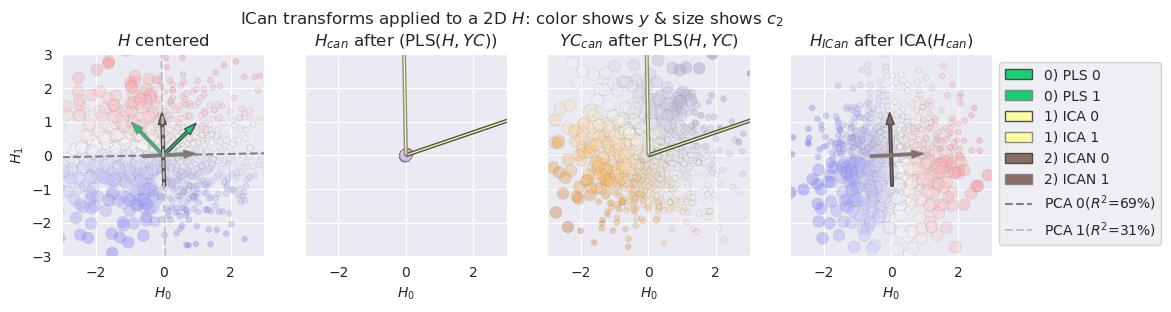

----------------------------------------------------------------------------------------------------
RUN 2/5
----------------------------------------------------------------------------------------------------
[INFO] PCA whitening transform dropped 2 redundant PLS components
ican vectors shape (10, 2)
[INFO] Top unique concepts: ['Y', 'C2']
[INFO] remapping ICan vectors as {}


,Y,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,Ypred,noise
true H0,0.00,0.00,0.00,-0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.30,0.01
true H1,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.50,0.02
true H2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01


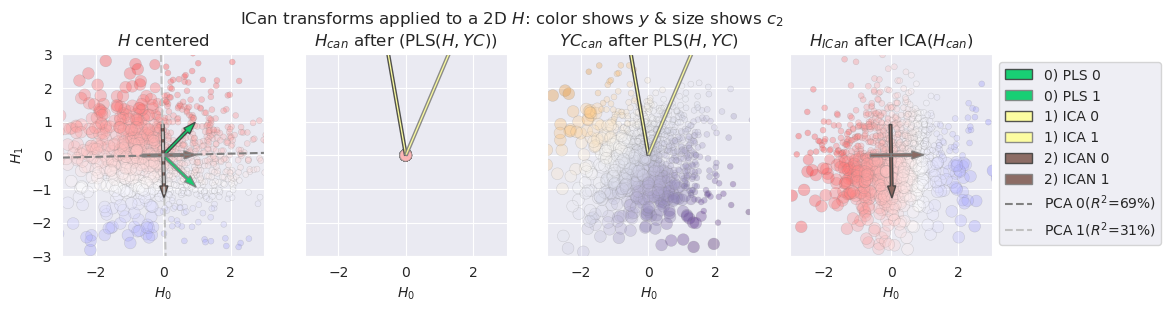

----------------------------------------------------------------------------------------------------
RUN 3/5
----------------------------------------------------------------------------------------------------
[INFO] PCA whitening transform dropped 2 redundant PLS components
ican vectors shape (10, 2)
[INFO] Top unique concepts: ['C2', 'Y']
[INFO] remapping ICan vectors as {'ICAN1': 'ICAN0', 'ICAN0': 'ICAN1'}


,Y,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,Ypred,noise
true H0,0.00,0.00,0.00,-0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.30,0.01
true H1,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.50,0.02
true H2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01


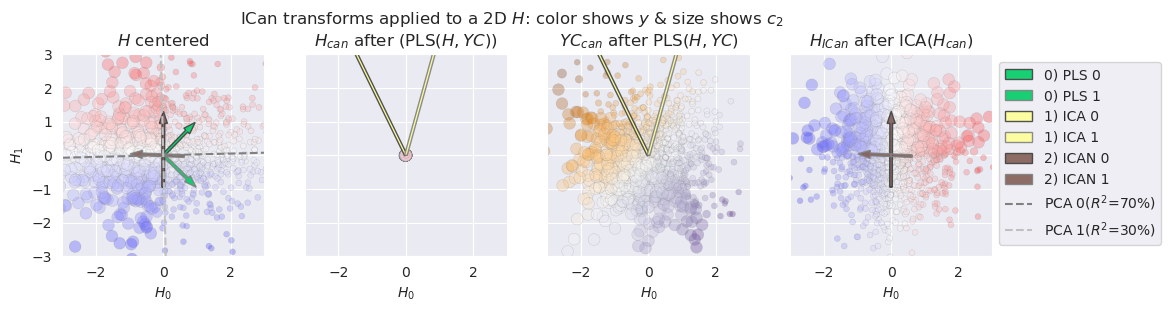

----------------------------------------------------------------------------------------------------
RUN 4/5
----------------------------------------------------------------------------------------------------
[INFO] PCA whitening transform dropped 2 redundant PLS components
ican vectors shape (10, 2)
[INFO] Top unique concepts: ['C2', 'Y']
[INFO] remapping ICan vectors as {'ICAN1': 'ICAN0', 'ICAN0': 'ICAN1'}


,Y,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,Ypred,noise
true H0,0.00,0.00,0.00,-0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.30,0.01
true H1,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.50,0.02
true H2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01


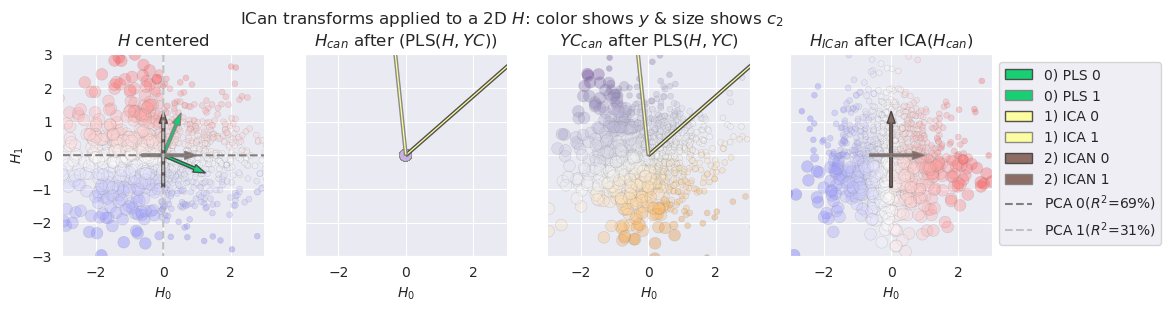

----------------------------------------------------------------------------------------------------
RUN 5/5
----------------------------------------------------------------------------------------------------
[INFO] PCA whitening transform dropped 2 redundant PLS components
ican vectors shape (10, 2)
[INFO] Top unique concepts: ['Y', 'C2']
[INFO] remapping ICan vectors as {}


,Y,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,Ypred,noise
true H0,0.00,0.00,0.00,-0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.30,0.01
true H1,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.50,0.02
true H2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
true H9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01


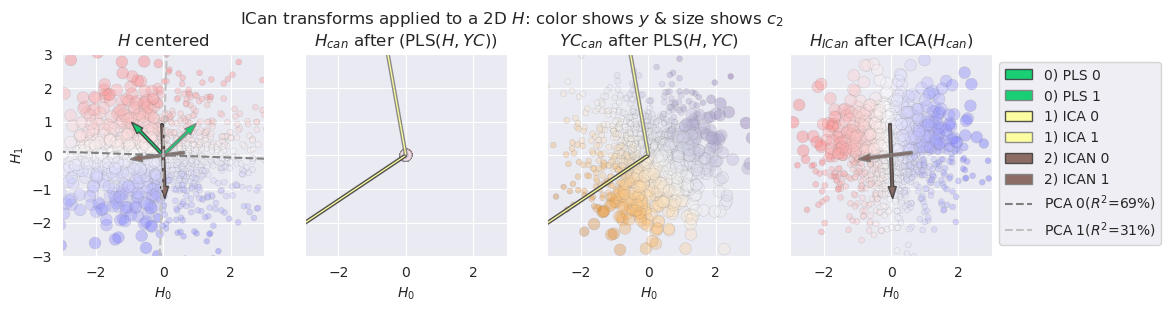

In [204]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, adjusted_mutual_info_score
    
if RUN_ican_sim:
    np.set_printoptions(precision=2, suppress=True)
    sns.set_style('darkgrid')

    ### (1) Globals 
    
    f = 10
    n = 1000
    N_COMPS = 4
    RUNS = 5

    unjumble = True
    verbose = 2

    # repeat the whole thing 5 times
    for run in range(RUNS):
        print('-'*100)
        print(f"RUN {run+1}/{RUNS}")
        print('-'*100)
        rng = np.random.RandomState(run) 
        Y = rng.logistic(size=(n))  # np.random.randn(n) 
        rng = np.random.RandomState(run+10000) 
        C = rng.logistic(scale=3, size=(n,10)) # np.random.randn(n,10) 

        yc_names = ['Y']+['C'+str(i) for i in range(C.shape[-1])]
        df_true_signals = pd.DataFrame(0, columns = yc_names + ['Ypred', 'noise'],
                                       index=[f'H{i}' for i in range(f)], dtype=float)
        
        # df_true_signals.loc['H0', 'Y']  = -0.1
        df_true_signals.loc['H0', 'C2'] = -0.3
        df_true_signals.loc['H0', 'C8'] = +0.0
        df_true_signals.loc['H0', 'noise'] = 0.01
        df_true_signals.loc['H1', 'Y']  = +0.6
        # df_true_signals.loc['H1', 'C2'] = +0.2
        df_true_signals.loc['H1', 'C8'] = +0.0
        df_true_signals.loc['H1', 'noise'] = 0.02

        for i in range(2, f):
            df_true_signals.loc[f'H{i}', 'noise'] = 0.01
            # df_true_signals.loc[f'H{i}', 'C8'] = np.random.uniform(-1, 1)*0.1

        df_true_signals.loc['H0', 'Ypred'] = +0.3
        df_true_signals.loc['H1', 'Ypred'] = -0.5

        def _get_var(k):
            if k=='noise': return 1
            elif k=='Y': return Y
            elif 'C' in k: return C[:,int(k.replace('C',''))]
            elif 'Ypred' in k: return 0.0
            else: raise ValueError(f"Unknown variable {k}")
        
        H = []
        for h,row in df_true_signals.iterrows():
            h_val = np.zeros(n)
            for k,v in row.items():
                # print(h, k, v, _get_var(k))
                h_val += v*_get_var(k)
            H.append(h_val)
        X =  np.c_[H].T

        YC = np.concatenate([Y.reshape(-1,1), C], axis=-1)
        if run==0: 
            print("shapes of [H, y, C] = [{}, {}, {}]".format(X.shape, Y.shape, C.shape))

        ### (2) Compute ican
        X_ican, ican_vecs, YC_weights, n_comps_new, (pls, (X_pls, YC_pls), ica) = compute_ICan(X, YC, 
                                                                                  n_components=N_COMPS,
                                                                                  yc_names=yc_names,
                                                                                  unjumble=unjumble,
                                                                                  verbose=verbose)      
         
        # show the True parameters configured in the data (dependences of H on YC)
        df_true_signals.index = ['true '+idx for idx in df_true_signals.index]
        df_true_signals.loc['true total_params'] = df_true_signals.abs().sum(axis=0)
        df_true_signals.loc['true total_params'] /= df_true_signals.loc['true total_params', yc_names].sum()

        # show the beta scores of YC variables after unjumbling
        # YC_weights.index = ['betas '+idx for idx in YC_weights.index]
        # YC_weights.loc['betas total_params'] = YC_weights.abs().sum(axis=0)
        # YC_weights.loc['betas total_params'] /= YC_weights.loc['betas total_params'].sum() 
        YC_weights = pd.concat([df_true_signals, YC_weights])

        # show the accuracy of estimation of the PLS for all the YC variables
        YC_est = pls.predict(X)
        for i,yc in enumerate(yc_names):
            mse = mean_squared_error(YC[:,i], YC_est[:,i])
            YC_weights.loc['MSE(YC_pls)', yc] = mse
            r2 = r2_score(YC[:,i], YC_est[:,i])
            r2 = 0 if r2<0 else r2 # forced r2 lower than 0 to zero
            YC_weights.loc['R2(YC_pls)', yc] = r2
        YC_weights.loc['MSE(YC_pls)'] /= -YC_weights.loc['MSE(YC_pls)'].max() ## HACK: scale the MSE to [-1,0] for better visualization

        # YC_weights.loc[:, 'Ypred'] = np.nan
        display(YC_weights.style.format(precision=2).background_gradient(cmap='RdBu', vmax=1, vmin=-1))


        ### (3) Create the figure
        fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharex=True, sharey=True)
        hdls, lbls = [], []

        axes = axes.ravel()
        [ax.set_xlabel(r'$H_0$') for ax in axes]
        axes[0].set_ylabel(r'$H_1$')
        common_settings = dict(hue=Y,  palette='bwr', size=C[:,2], size_norm=(0, 1), edgecolors='grey', alpha=0.3, legend=False)

        ### (3a) make a scatterplot of true data X
        ax = axes[0]
        meaner = (np.eye(n) - (1/n)*np.ones((n,n)))
        basis = meaner @ X
        ax.set_title(r"$H$ centered")
        sns.scatterplot(x=basis[:, 0], y=basis[:, 1], 
                        ax=ax,
                        **common_settings)
        # ica_raw = FastICA(n_components=None, max_iter=5000)
        # ica_raw.fit(basis) 
        plot_ican_arrows(ax, basis=basis, n_comp=n_comps_new,
                          pls=pls, ica=ica, ican_vecs=ican_vecs, 
                          show_vecs=['PLS', 'ICAN', 'PCA'])  

        for h,l in zip(*ax.get_legend_handles_labels()):
            if l not in lbls:
                lbls.append(l)
                hdls.append(h)


        ### (3b) plot the ican arrows on a scatter plot of the PLS Xcanonicals instead
        # Plot the modified data
        ax = axes[1]
        basis = X_pls
        ax.set_title(r"$H_{can}$ after (PLS$(H, YC)$)")
        sns.scatterplot(x=basis[:, 0], y=basis[:, 1], 
                        ax=ax, 
                        **common_settings)
        # Plot the canonical vectors
        plot_ican_arrows(ax, basis=basis, n_comp=n_comps_new,
                        pls=pls, ica=ica, ican_vecs=ican_vecs, 
                        show_vecs=['ICA'])

        for h,l in zip(*ax.get_legend_handles_labels()):
            if l not in lbls:
                lbls.append(l)
                hdls.append(h)
        
        # for i in range(pls.n_components):
        #     ax.arrow(0, 0, pls.x_weights_[0,i], pls.x_weights_[1,i], 
        #               color='yellow', width=0.05, alpha=1-(0.8/N_COMPS)*i,
        #               label=f"CCA X weights {i}")
        # for i in range(pls.n_components):
        #     ax.arrow(0, 0, pls.x_rotations_[0,i], pls.x_rotations_[1,i], 
        #               color='yellow', width=0.05, alpha=1-(0.8/N_COMPS)*i,
        #               label=f"CCA X rotations {i}")


        ### (3d) plot the ican arrows on a scatter plot of the PLS+ICA space
        ax = axes[3]
        basis = X_ican
        # print(basis.shape, X_myican.shape)
        # assert np.isclose(X_ican, my_X_ican, atol=1e-3).all(), "Something wrong with my way of computing the final ICAN matrix"
        ax.set_title(r"$H_{ICan}$ after ICA($H_{can}$)")
        # ax.set_title(r"$PCA(X)$")
        sns.scatterplot(x=basis[:,0], y=basis[:,1],
                        ax=ax,  
                        **common_settings)
        plot_ican_arrows(ax, basis=basis, n_comp=n_comps_new,
                        pls=pls, ica=ica, ican_vecs=ican_vecs, 
                          show_vecs=['ICAN'])
        # ax.legend()
        for h,l in zip(*ax.get_legend_handles_labels()):
            if l not in lbls:
                lbls.append(l)
                hdls.append(h)

        ### (3c) plot the ican arrows on a scatter plot of the PLS and Ycanonicals instead
        ax = axes[2]
        basis = YC_pls
        ax.set_title(r"$YC_{can}$ after PLS$(H, YC)$")
        # ax.set_title(r"$PCA(X)$")
        common_settings['palette'] = 'PuOr'
        sns.scatterplot(x=basis[:,0], y=basis[:,1],
                        ax=ax,  
                        **common_settings)
        plot_ican_arrows(ax, basis=basis, n_comp=n_comps_new,
                        pls=pls, ica=ica, ican_vecs=ican_vecs, 
                         show_vecs=['ICA'])
        # ax.legend()
        for h,l in zip(*ax.get_legend_handles_labels()):
            if l not in lbls:
                lbls.append(l)
                hdls.append(h)
        # resort alphabetically
        lbls, hdls = zip(*sorted(zip(lbls, hdls), key=lambda x: x[0]))

        # plt.tight_layout()
        # plot the legend outside the figure
        plt.figlegend(hdls, lbls, loc='center left', bbox_to_anchor=(0.9,0.5))
        fig.suptitle(f"ICan transforms applied to a 2D " + r"$H$" + ": color shows "+ r"$y$" +f" & size shows "+ r"$c_2$")
        plt.show()

In PLS, what is the relation between - 
```
W = pls.x_weights_
L = pls.x_loadings_
R = pls.x_rotations_
```
?
1. $W.L^T \approx I$
2. $R.L^T \approx I$
3. $W.R^T \approx I$
1. $W = (L + X) / 2$ 

In [198]:
# trans = pls.transform(np.eye(*pls.x_rotations_.shape))
# print("loadings", (trans - pls.x_loadings_).ravel().tolist())
# print("rot     ", (trans - pls.x_rotations_).ravel().tolist())
# print("weights ", (trans - pls.x_weights_).ravel().tolist())

### Compute CCA+ICA (ICan) on Toybrains
Independant canonical concepts or ICans

In [230]:
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics.pairwise import cosine_similarity

def compute_ICan(X, YC, n_components=2,
                 yc_names=None, 
                 unjumble=True, return_corrs=False,
                 verbose=0):
    if yc_names is None:
        yc_names = ['Y']+['C'+str(i) for i in range(YC.shape[-1]-1)]
    else:
        assert len(yc_names) == YC.shape[-1], f"the number of names {len(yc_names)} should match the number of columns in yc {yc.shape[-1]}"

    ### apply CCA on H(l-1) vs [lbl_lesion, cov_site]
    pls = PLSCanonical(n_components=n_components, 
                       algorithm='nipals',
                       scale=True, max_iter=5000)
    X_pls, YC_pls = pls.fit_transform(X, YC)

    # apply PCA to whiten the data and remove redundant components with high similarity
    pca = PCA(n_components=0.999, whiten=False, svd_solver='full')
    X_pls_pca = pca.fit_transform(X_pls)
    n_comps_reduced = X_pls_pca.shape[-1]

    if verbose>0 and X_pls_pca.shape[-1] < X_pls.shape[-1]: 
        print(f"[INFO] PCA whitening transform dropped {X_pls.shape[-1]-X_pls_pca.shape[-1]} redundant PLS components")
    
    ### drop PLS components that are very similar (cosine similarity>0.9) as they are likely redundant and would confuse fastICA
    # create a list with all possible pairs of components
    # component_pairs_to_check = [(i, j) for i in range(n_components) for j in range(n_components) if i!=j and i<j]
    # component_pairs_all = copy(component_pairs_to_check)
    # drop_comps = []
    # for i,j in component_pairs_all:
    #     if (i,j) in component_pairs_to_check:
    #         abs_cos_sim = np.abs(cosine_similarity(X_pls[:,i].reshape(1,-1), X_pls[:,j].reshape(1,-1))[0][0])
    #         component_pairs_to_check.remove((i,j))
    #     if abs_cos_sim>0.8:
    #         drop_comps.append(j)
    #         # remove all pairs from component_pairs_to_check that contain j
    #         [component_pairs_to_check.remove((ii,jj)) for (ii,jj) in component_pairs_to_check if (jj==j) or (ii==j)]
    #         # print(f"[WARN] Dropping component H{j} as its abs. cosine similarity with H{i} is very high ({abs_cos_sim:0.2f})")
    
    # n_comps_reduced = n_components
    # X_pls_new = deepcopy(X_pls)
    # if len(drop_comps)>0:
    #     X_pls_new = np.delete(X_pls_new, drop_comps, axis=-1)
    #     n_comps_reduced -= 1
    #     print(f"[INFO] Dropping redundant components {[f'H{i}_pls' for i in drop_comps]}")
    # dropper = np.eye(n_components)
    # dropper = np.delete(dropper, drop_comps, axis=-1)

    # apply ICA 
    ica = FastICA(whiten='unit-variance', max_iter=50000, tol=1e-5)
    X_ican = ica.fit_transform(X_pls_pca) 
        
    ### Calculate the ICan vectors by combining all the operations performed by PLS and ICA together
    n,f = X.shape
    # mean and std_dev
    I = np.eye(n)
    meaner = (I - (1/n)*np.ones((n,n)))
    ## calculate the ICAN transformation matrix 
    pls_std = np.zeros((f,f))
    np.fill_diagonal(pls_std, 1/pls._x_std)

    ican_vecs = pls_std @ pls.x_rotations_ @ pca.components_.T @ ica.components_.T
    if verbose>0: print(f"ican vectors shape {ican_vecs.shape}")

    ### compute the ICan transforms
    my_X_ican = meaner @ X @ ican_vecs
    # sanity: ensure that my estimation of X_ican is same as the output of the sklearn method before resorting the ICans
    err = (np.abs(my_X_ican-X_ican))
    if np.abs(err.mean())>1e-4:
        print(f"[ERROR] my_X_ican ~ X_ican = {err.mean():.4f} +- {err.std():.4f}. \
Is something wrong in the way I compute the ICan tranformation vectors?")
        # determine where exactly the problem lies
        err_ = (np.abs(meaner @ X - (X - pls._x_mean)))
        if err_.mean()>1e-4:
            print(f"[ERROR] The error is in the meaner matrix of {err_.mean():.4f} +- {err_.std():.4f}")
        err_ = (np.abs(meaner @ X @ pls_std - (X - pls._x_mean)/pls._x_std))
        if err_.mean()>1e-4:
            print(f"[ERROR] The error is in the standardizer matrix of {err_.mean():.4f} +- {err_.std():.4f}")
        err_ = (np.abs(meaner @ X @ pls_std @ pls.x_rotations_ - X_pls))
        if err_.mean()>1e-4:
            print(f"[ERROR] The error is in the estimated PLS rotation matrix of {err_.mean():.4f} +- {err_.std():.4f}")
        err_ = (np.abs(meaner @ X @ pls_std @ pls.x_rotations_ @ pca.components_.T - X_pls_pca))
        if err_.mean()>1e-4:
            print(f"[ERROR] The error is in the estimated whitening matrix of {err_.mean():.4f} +- {err_.std():.4f}")
        err_ = (np.abs(meaner @ X @ pls_std @ pls.x_rotations_ @ pca.components_.T @ ica.components_.T - X_ican))
        if err_.mean()>1e-4:
            print(f"[ERROR] The error is in the estimated ICA rotation matrix of {err_.mean():.4f} +- {err_.std():.4f}")
            
        my_X_ican = X_ican
    
    # compute the relavance of YC to the ICan transform
    # pls_std_y = np.zeros((pls.y_rotations_.shape[0], pls.y_rotations_.shape[0]))
    # np.fill_diagonal(pls_std_y, 1/pls._y_std)

    # df_corrs = pls.y_rotations_.T #(pls_std_y @ pls.y_rotations_ @ ica.components_.T).T
    # df_corrs = pd.DataFrame(df_corrs, 
    #                           columns=yc_names,
    #                           index=[f"YC{i}_pls" for i in range(n_components)])
    ycpls_cols = [f"pls_YC{i}" for i in range(n_components)] 
    hpls_cols = [f"pls_H{i}" for i in range(n_components)]
    hican_cols = [f"ICAN{i}" for i in range(n_comps_reduced)]
    df_corrs = pd.DataFrame(index=ycpls_cols+hpls_cols+hican_cols, columns=yc_names, dtype=float)    
    # show the correlations between the pls outputs [H_pls, YC_pls] and the individual YC variables
    for i in range(n_components):
        for j, yc_name in enumerate(yc_names):
            df_corrs.loc[f"pls_YC{i}", yc_name] = compute_dcor_sq(YC_pls[:,i], YC[:,j])
            df_corrs.loc[f"pls_H{i}", yc_name] = compute_dcor_sq(X_pls[:,i], YC[:,j])

    # show the correlations between the full ICAN output X_ican and the YC variables
    for i in range(n_comps_reduced):
        for j, yc_name in enumerate(yc_names):
            df_corrs.loc[f"ICAN{i}", yc_name] = compute_dcor_sq(my_X_ican[:,i], YC[:,j])
    
    ### reorder the ICan vectors by their order of association with the YC variables
    ican_vecs_unjumbled = deepcopy(ican_vecs)
    df_corrs_unjumbled = deepcopy(df_corrs) 

    if unjumble:
        # resort the ICAN vectors to align with yc_names this mitigates the jumbling of vectors by ICA 
        # top_unique_concepts = df_corrs.loc[hican_cols].sum(axis=0).sort_values(ascending=False).index.tolist()[:n_comps_reduced]
        # # resort the top concepts by the order they appear in YC
        # yc_og_order = {c: i for i,c in enumerate(df_corrs.columns)}
        # top_unique_concepts.sort(key = lambda c: yc_og_order[c])
        # sort the ICan vectors based on their corresponding strengths with the top concepts
        # resort the ICans by the order of their correlation strengths with the YC variables
        # find out which ICAN vector relates to which concept in YC
        top_unique_con_matches = []
        for hican_col in hican_cols:
            for con in df_corrs.loc[hican_col].sort_values(
                        ascending=False).index:
                if con not in top_unique_con_matches:
                    top_unique_con_matches.append(con)
                    break
        # resort the ICAN vectors to the same order as they appear in yc_names 
        # this is a hack that helps mitigates the jumbling of vector orders by ICA 
        top_unique_con_matches_sorted = sorted(top_unique_con_matches, key=lambda con: yc_names.index(con))
        ican_reorder_idx = [top_unique_con_matches.index(con) for con in top_unique_con_matches_sorted]
        ican_reorder_map = {f"ICAN{j}" : f"ICAN{i}" for i,j in enumerate(ican_reorder_idx) if i!=j}
        if verbose>0:         
            print(f"[INFO] Top unique concepts: {top_unique_con_matches}")
            if len(ican_reorder_map): print(f"[INFO] remapping ICan vectors as {ican_reorder_map}")
        # reorder the ICans
        ican_vecs_unjumbled = ican_vecs[:, ican_reorder_idx]
        assert ican_vecs.shape==ican_vecs_unjumbled.shape, "The shape of the ICan vectors should not change after reordering."
        # also reorder the names in df_corrs and resort them
        if len(ican_reorder_map):
            df_corrs_unjumbled = df_corrs_unjumbled.rename(index=ican_reorder_map)

    #     ### recompute the relavance of YC to the ICan transform
    #     df_corrs = (pls_std_y @ pls.y_rotations_ @ ica.components_.T).T
        # ican_reorder_yc = {}
        # for new_idx, old_idx in enumerate(ican_reorder_idx):
        #     ican_reorder_yc.update({f"dcor H_ican{old_idx}":f"dcor H_ican{new_idx}",
        #                             f"betas ican{old_idx}":f"betas ican{new_idx}"})
        # df_corrs_unjumbled = df_corrs.rename(index=ican_reorder_yc).sort_index()
        # df_corrs_unjumbled = pd.DataFrame(df_corrs_unjumbled, 
        #                                     columns=yc_names,
        #                                     index=[f"ICan{i}" for i in range(n_components)])
        # if verbose>0: 
        #     print(r"PLS(YC) relevance scores:")
        #     YC_weights_unjumbled_norm = YC_weights_unjumbled.copy().applymap(np.abs)
        #     YC_weights_unjumbled_norm = YC_weights_unjumbled_norm.apply(lambda arr: (arr - arr.min())/(arr.max()-arr.min()), axis=1)
        #     display(YC_weights_unjumbled_norm.style.format(precision=2).background_gradient(cmap='Purples', vmax=1, vmin=0))

        # recompute the ICan transforms
        my_X_ican = meaner @ X @ ican_vecs_unjumbled
    
    return my_X_ican, ican_vecs_unjumbled, df_corrs_unjumbled.sort_index(), n_comps_reduced, (pls, (X_pls, YC_pls), ica)

In [231]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif 
from sklearn.metrics import adjusted_mutual_info_score

def compute_mi(X,y):
    if X.ndim==1:
        X = X.reshape(-1,1)
        
    y = y.values.reshape(-1,)
    assert X.shape[0]==y.shape[0], f"the shape of the activations and covariates should be (N, D) and (N, 1)\
 respectively but they are {X.shape} and {y.shape} respectively"
    
    # check if y is continuous or categorical variable
    if isinstance(y[0], (int, str)):
        mi_score = mutual_info_classif(X, y)
    else:
        mi_score = mutual_info_regression(X, y)
    return mi_score



In [272]:
import matplotlib.transforms as mtrans
from sklearn.preprocessing import MinMaxScaler

def collect_ican_scores(
            logs, 
            n_comps=3, 
            sim_metrics={'dcor2': compute_dcor_sq},
            n_jobs=-1,
            verbose=0):

    def _collect_ican_score(dataset, model_name, run, log):

        # (1) load the confounds table
        df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
        # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

        # make the table values numerical using the DeepRepVizBackend
        drv = DeepRepVizBackend(conf_table=df_attrs, 
                                ID_col='subjectID', label_col='lbl_lesion', 
                                best_ckpt_by="test_loss")
        df_attrs = drv.df_conf 
        # reorder to match the IDs of the model results and the confound table
        df_attrs = df_attrs.loc[log['IDs']]
        assert np.all(log['IDs'] == df_attrs.index.values), "IDs do not match between the confound table and the model results."

        # choose the table of confounder variables to give to the ican compute
        df_attrs_selected = df_attrs.copy() # [['lbl_lesion', 'cov_site',]]
        # append the predicted logits
        # df_attrs_selected.insert(loc=0, column="y_pred", value=log['y_pred'])
        # df_attrs["y_pred_class"] = log['y_pred']>0.5
        # for selected variables in the metadata table compute the ican metrics
        conf_subset =  df_attrs_selected.columns.tolist() #['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
        
        # set the N_COMPONENTS of icans same as the number of confound variables + lbl
        # N_COMPONENTS = np.min([*log['act'].shape, 5]) # sklearn: Number of components to keep should be in [1, min(n_samples, n_features, n_targets)].

        ### (2) Compute CCA+ICA
        # try: 
        X_ican, ican_vecs, YC_weights, n_comps_new, _ = compute_ICan(
                                                            X=log['act'], YC=df_attrs_selected.values, 
                                                            n_components=n_comps,
                                                            yc_names=conf_subset,
                                                            unjumble=True, 
                                                            verbose=verbose)

        # except Exception as e:
            # print(f"[ERROR] ican failed to converge for {model_name} on {dataset} at run {run}. Skipping... \n{e}")
            # return (dataset, model_name, run), pd.DataFrame()

        # save the d-correlations from the ICAN computation
        df_scores = pd.DataFrame(columns=conf_subset, dtype=float)  
        ican_colnames = [f"ICAN{i}" for i in range(n_comps_new)]
        score_col = copy(ican_colnames)
        metric_col = ['dcor']*len(ican_colnames)
        # add more columns for all the additional metrics requested
        # ypred_colname = 'y_pred'
        # for metric_name in sim_metrics.keys():
        #     if metric_name.lower()!='dcor':
        #         score_col += [ypred_colname, *ican_colnames]
        #         metric_col += [metric_name]*(len(ican_colnames)+1)     
         # instantiate all rows of the dataframe to populate
        df_scores.loc[:,'score'] = score_col
        df_scores.loc[:,'metric'] = metric_col
        df_scores.loc[:,'test_acc'] = [log['test_acc']]*len(score_col)
        df_scores.loc[:,'Atrue'] = [log['Atrue']]*len(score_col)
        df_scores.loc[:,'Aconf'] = [log['Aconf']]*len(score_col)
        df_scores = df_scores.set_index(['score', 'metric'], drop=True)

        # # first fill the ICAN computed dCor as a metric 
        YC_weights = YC_weights.map(lambda x: x if np.abs(x)>1e-5 else 0) # set small values to zero
        df_scores.loc[(ican_colnames, ['dcor']*(len(ican_colnames))), conf_subset] = YC_weights.loc[ican_colnames].values
        # display(df_scores)
        
        # ### compute other similarity metrics (Ex: MI()) between ican components and all the confound variables
        # for conf in conf_subset:
        #     conf_var = df_attrs_selected[conf] 
            
        #     for sim_metric_name, sim_metric_fn in sim_metrics.items():
        #         if metric_name.lower()!='dcor': # already computed
        #             # for comparison, also compute the similarity between the y_pred_logit and all the confound variables
        #             df_scores.at[(ypred_colname, sim_metric_name), conf] = sim_metric_fn(log['y_pred'].astype(float),
        #                                                                                     conf_var.astype(float))
        #             # compute the dCor2() between ican components and all the confound variables
        #             for i, col in enumerate(ican_colnames):
        #                 df_scores.at[(col, sim_metric_name), conf] = sim_metric_fn(X_ican[:,i], 
        #                                                                             conf_var.astype(float))
        # display(df_scores)

        return (dataset, model_name, run), df_scores

    # parallelize the computation of ican scores across datasets
    results_tuple = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(_collect_ican_score)(*log_tuple) for log_tuple in tqdm(logs))

    df_results_ican = pd.concat(dict(results_tuple), 
                                 names=['dataset', 'model_name', 'trial', 'score', 'metric'])
    # sort the dataframe by lognames
    df_results_ican = df_results_ican.sort_index(level=['model_name', 'trial']).sort_index(
                                                                                    level=0) # 'dataset', key=np.vectorize(lognames_sortrank))
    return df_results_ican


In [274]:
if RUN_ican:
    DEBUG_MODE = False
    
    df_icans = collect_ican_scores(logs,
                                    n_comps=3, 
                                    sim_metrics={
                                                # 'dcor2': compute_dcor_sq, 
                                                # 'mi': compute_mi,
                                                },
                                    n_jobs=-1 if not DEBUG_MODE else 1, 
                                    verbose=0 if not DEBUG_MODE else 1)
    display(df_icans)
    if not DEBUG_MODE:
        df_icans.reset_index().to_csv(f"results/df_icans_{EXP_NAME}.csv", index=False)

  0%|          | 0/225 [00:00<?, ?it/s]

/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


cov_site  \
dataset           model_name        trial   score metric             
cy000-cX000-yX000 SimpleCNN_c1-f003 trial_0 ICAN0 dcor    0.000000   
                                            ICAN1 dcor    0.000000   
                                            ICAN2 dcor    0.000000   
                                    trial_1 ICAN0 dcor    0.000000   
                                            ICAN1 dcor    0.000000   
...                                                            ...   
cy100-cX100-yX100 SimpleCNN_c1-f256 trial_1 ICAN1 dcor    0.007984   
                                            ICAN2 dcor    0.000014   
                                    trial_2 ICAN0 dcor    0.278328   
                                            ICAN1 dcor    0.000302   
                                            ICAN2 dcor    0.004050   

                                                          lbl_lesion  \
dataset           model_name        trial   score metric               
cy000-cX000-yX000 SimpleCNN_c1-f003 trial_0 ICAN0 dcor      0.000000   
                                            ICAN1 dcor      0.000000   
                                            ICAN2 dcor      0.000000   
                                    trial_1 ICAN0 dcor      0.000000   
                                            ICAN1 dcor      0.000000   
...                                                              ...   
cy100-cX100-yX100 SimpleCNN_c1-f256 trial_1 ICAN1 dcor      0.007984   
                                            ICAN2 dcor      0.000014   
                                    trial_2 ICAN0 dcor      0.278328   
                                            ICAN1 dcor      0.000302   
                                            ICAN2 dcor      0.004050   

                                                          brain-int_border  \
dataset           model_name        trial   score metric                     
cy000-cX000-yX000 SimpleCNN_c1-f003 trial_0 ICAN0 dcor            0.007322   
                                            ICAN1 dcor            0.000625   
                                            ICAN2 dcor            0.004551   
                                    trial_1 ICAN0 dcor            0.031554   
                                            ICAN1 dcor            0.000436   
...                                                                    ...   
cy100-cX100-yX100 SimpleCNN_c1-f256 trial_1 ICAN1 dcor            0.000049   
                                            ICAN2 dcor            0.001061   
                                    trial_2 ICAN0 dcor            0.000000   
                                            ICAN1 dcor            0.000038   
                                            ICAN2 dcor            0.001649   

                                                          brain-int_fill  \
dataset           model_name        trial   score metric                   
cy000-cX000-yX000 SimpleCNN_c1-f003 trial_0 ICAN0 dcor          0.001449   
                                            ICAN1 dcor          0.046441   
                                            ICAN2 dcor          0.001530   
                                    trial_1 ICAN0 dcor          0.040249   
                                            ICAN1 dcor          0.003274   
...                                                                  ...   
cy100-cX100-yX100 SimpleCNN_c1-f256 trial_1 ICAN1 dcor          0.009466   
                                            ICAN2 dcor          0.000486   
                                    trial_2 ICAN0 dcor          0.286508   
                                            ICAN1 dcor          0.000337   
                                            ICAN2 dcor          0.004292   

                                                          brain-vol_radmajor  \
dataset           model_name        trial   score metric                       
cy000-cX000-yX000 SimpleCNN_c1-f003 trial_0 IC

### Visualize ICans

### Plot ican similarities in each dataset and model

In [266]:
def plot_ican_scores(df_icans, metric='dcor2', fs=10, datasets_subset=[]):

    df = df_icans.copy().reset_index()
    assert metric in df['metric'].unique(), f"Invalid metric. Available metrics in df_icans are [{list(df['metric'].unique())}]"
    df = df[df['metric']==metric]

    datasets_subset = [d.lower() for d in datasets_subset]
    for dataset, dfi in df.groupby('dataset'):
        if len(datasets_subset)>0 and (dataset.lower() not in datasets_subset):
            continue
        
        n_cols = dfi.groupby(['model_name', 'trial']).ngroups
        fig, axes = plt.subplots(1, n_cols, 
                                sharex=True, sharey=True, 
                                figsize=(2+2*n_cols, 1+5),
                                )
        axes = axes.flatten()
        
        model_change = []
        last_model = ''
        for m, ((model_name, trial), dfi_scores) in enumerate(dfi.groupby(['model_name', 'trial'])):            
            ax = axes[m]
            # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Trial:{trial}")
            # store the axis idx when the model changes for drawing an indicative seperation line later
            if last_model == '':
                model_change.append((model_name, False))
                last_model = model_name
            elif last_model != model_name:
                model_change.append((model_name, True))
                last_model = model_name
            else:
                model_change.append((model_name, False))

            ### plot on the axis
            ican_colnames = [c for c in dfi_scores['score'].unique() if 'ican' in c.lower()]

            test_acc = dfi_scores['test_acc'].iloc[0]
            Atrue = dfi_scores['Atrue'].iloc[0]
            Aconf = dfi_scores['Aconf'].iloc[0]
            dfi_scores = dfi_scores.set_index('score').drop(columns=['dataset', 'model_name', 'trial', 'metric', 
                                                                     'test_acc', 'Atrue', 'Aconf'])
            
            dfi_scores = dfi_scores.astype(float)
            
            # first plot the icans as a stacked plot
            dfi_scores.loc[ican_colnames].T.plot.barh(ax=ax,
                                    position=0.0, width=0.7, stacked=True)
            # then plot the yhat(logit) as a separate grey bar below the icans
            ypred_colname = 'y_pred'
            if ypred_colname in dfi_scores.index:
                dfi_scores.loc[ypred_colname].T.plot.barh(ax=ax,
                                        color='dimgrey', position=1.0, width=0.4) 
            
            
            ax.set_title(f"{model_name} \n{trial} (acc={test_acc*100:.0f}%)", 
                            fontsize=fs, loc='left')
            
            if ax.get_xlim()[0]>=0: 
                ax.set_xlim( 0., 1.)
            else:
                ax.set_xlim(-1., 1.)
            if m==0:  # only draw the legend for the first plot
                ax.legend(ncols=4, 
                            bbox_to_anchor=(0.9,1), bbox_transform=fig.transFigure,
                            prop={'size': fs})
            else:
                ax.get_legend().remove()
                # ax.set_yticklabels(ax.get_yticklabels(), fontsize=fs)
        fig.suptitle(f"Dataset: {dataset} ( A_true = {Atrue}% , A_conf = {Aconf}% )",
                     fontsize=fs+2)

        ### draw verticle lines to separate different model_name
        # Get the bounding boxes of the axes including text decorations
        with warnings.catch_warnings(): # catch and ignore FutureWarning
            warnings.simplefilter(action='ignore', category=FutureWarning)
            r = fig.canvas.get_renderer()
            get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
            bboxes = np.array(list(map(get_bbox, axes.flat)), mtrans.Bbox).reshape(axes.shape)
            #Get the H1 coordinate of each bounding box
            xmax = np.array(list(map(lambda b: b.x0, bboxes.flat)))
            # Draw a verticle lines at the coordinates where the model_name changes
            for x, (_, changed) in zip(xmax, model_change):
                if changed:
                    line = plt.Line2D([x-0.01,x-0.01], [0.05,0.95], transform=fig.transFigure, 
                                    linestyle=':', color='grey', linewidth=2)
                    fig.add_artist(line)
            
            # plt.tight_layout()
            plt.show()

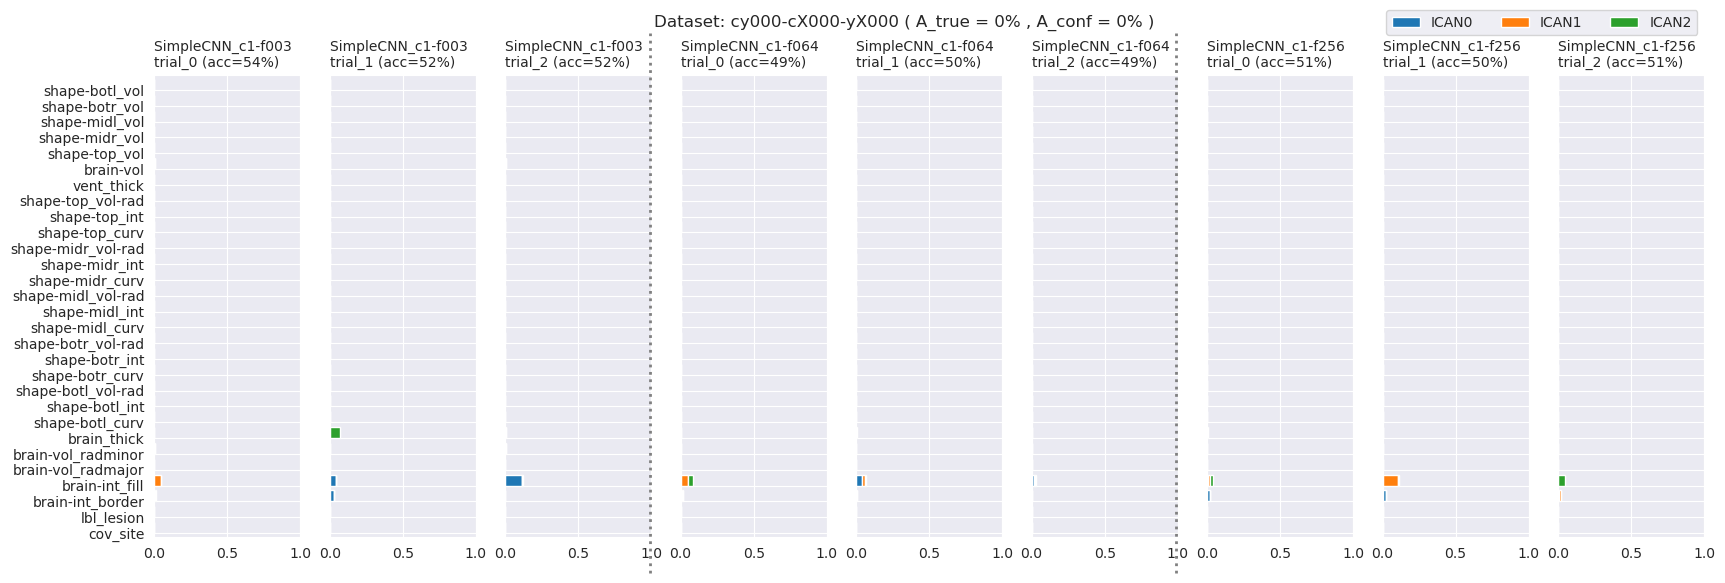

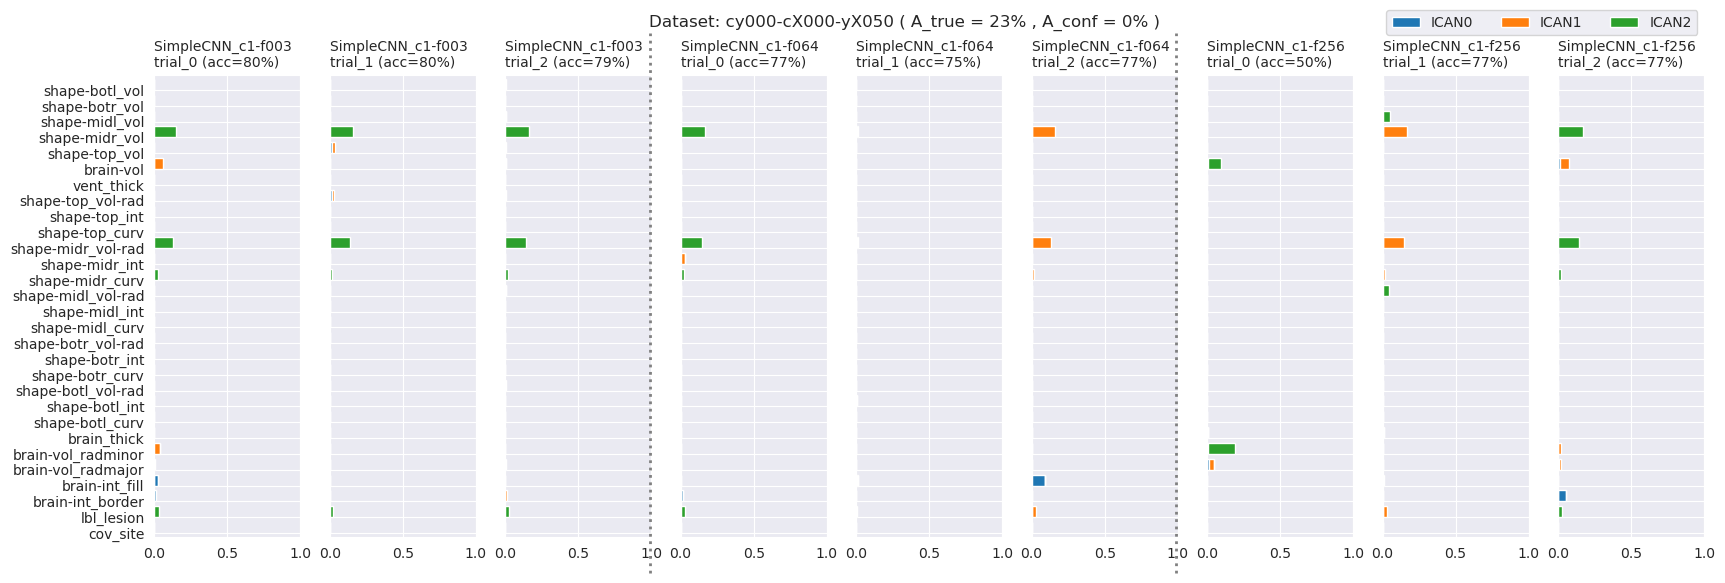

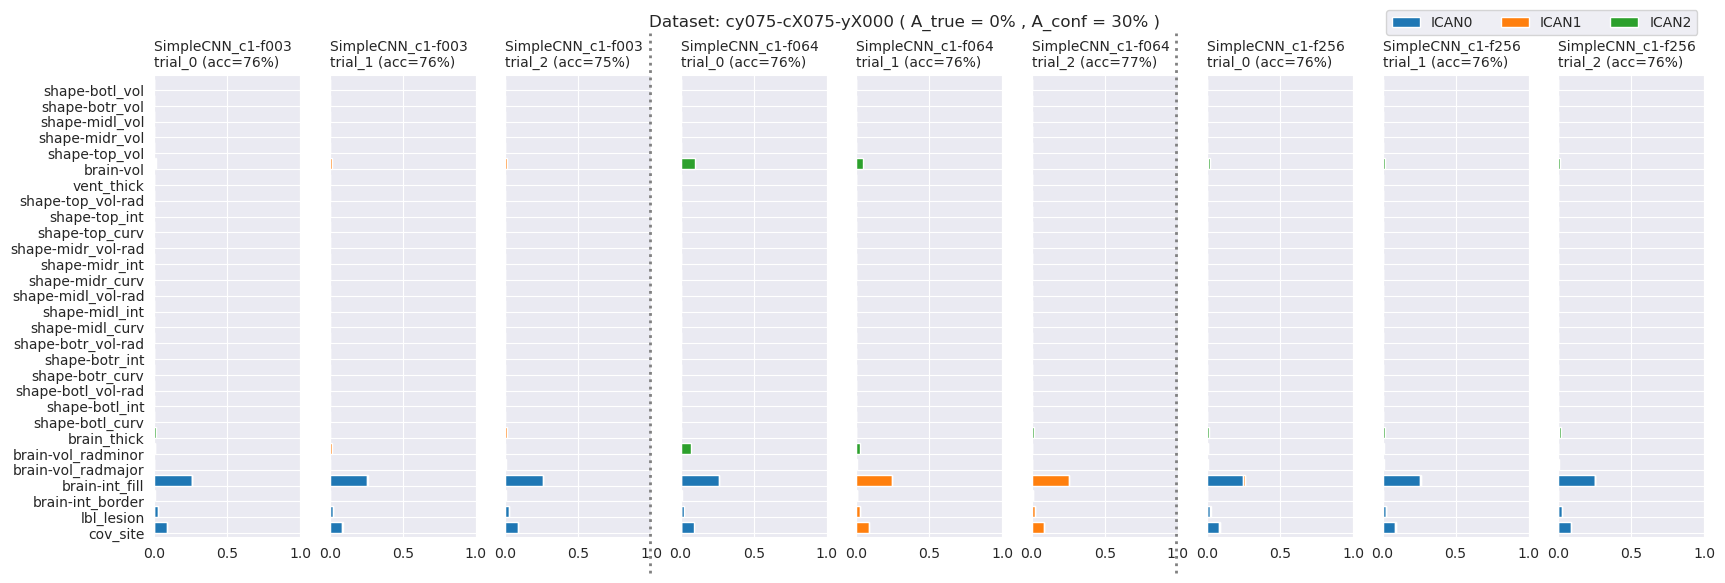

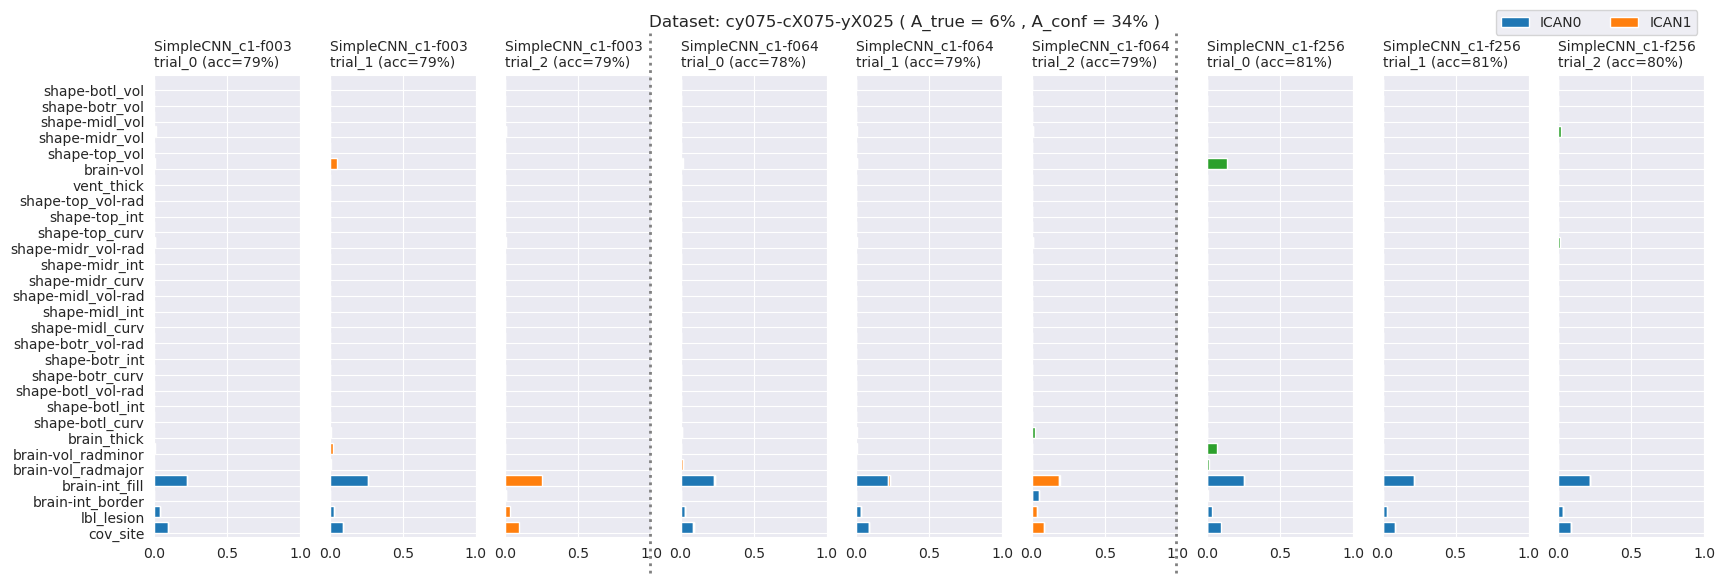

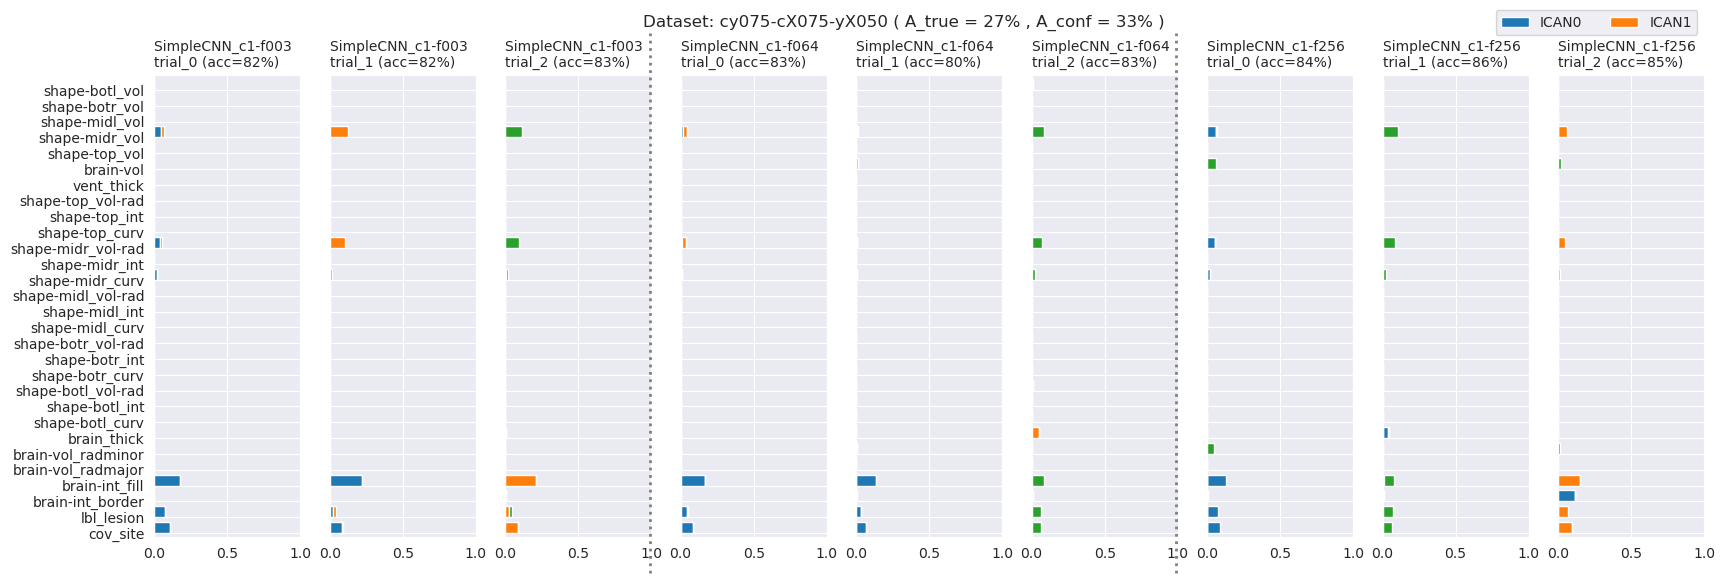

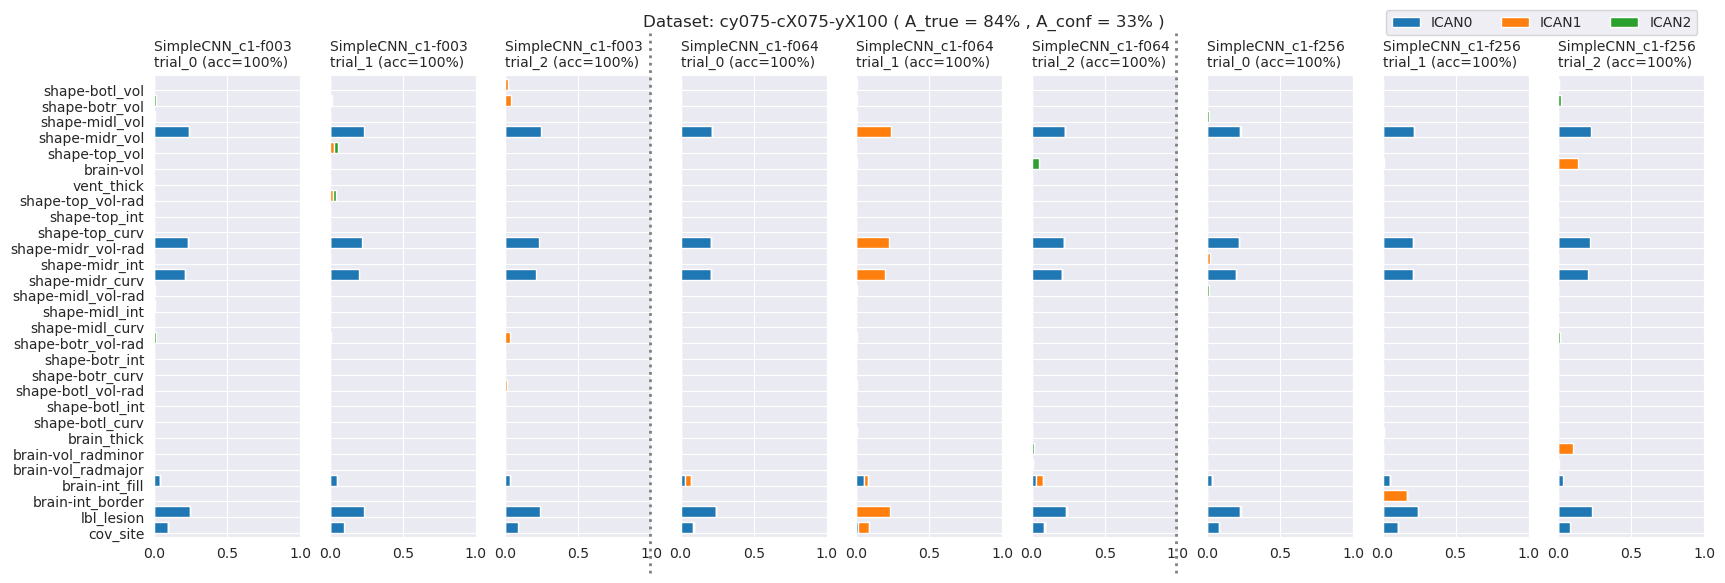

In [268]:
if RUN_ican:
    plot_ican_scores(df_icans, metric='dcor',
                      datasets_subset=['cy000-cX000-yX000', 'cy000-cX000-yX050', 
                                       'cy075-cX075-yX000', 
                                       'cy075-cX075-yX025',  'cy075-cX075-yX050', 'cy075-cX075-yX100']
                      )

In [ ]:
# if RUN_ican:
#     plot_ican_scores(df_icans, reorder_icans=True, metric='mi',
#                       datasets_subset=['cy000-cH000-yH000', 'cy000-cH000-yH025', 
#                                        'cy075-cH075-yH000', 
#                                        'cy075-cH075-yH025',  'cy075-cH075-yH050', 'cy075-cH075-yH100']
#                       )

### Compare $ICan_i$ with $A_{conf}$ 

In [ ]:
# plot the datasets on the X-axis and the  D2(Aconf) and D2(Atrue) on the Y-axis as
def compare_score_with_true(df_scores, metric=None,
                            confounds=['brain-int_fill'], trues=['shape-midr_vol-rad'],  reorder_icans=False,
                            df_model=df_results, model_metric='BAC_test', model_name_filter='.*'):

    ### (1) Clean and prepare the df with model accuracies across datasets
    # drop the indexes 'model_name' and 'trial' and only keep the 'dataset' as index 
    df_model = df_model.copy()
    # flatten the multi-index columns & select only the metric requested
    df_model = df_model.droplevel(level=0, axis='columns').filter(like=model_metric)

    ### (2) Clean and prepare the df with ican scores
    df_scores = df_scores.copy().reset_index()
    
    if metric is not None: # filter out only the metric to requested
        df_scores = df_scores[df_scores['metric']==metric]
    else: # append the metric to the score column
        df_scores['score'] = df_scores['score'] + ' (' + df_scores['metric'] + ')'
    # now drop the metric column
    if 'metric' in df_scores.columns:
        df_scores = df_scores.drop(columns=['metric'])
    
    if reorder_icans:
        # reorder the icans based on their strengths of association with y_pred (ican0 has the highest association)
        df_scores_new = []
        for (idx), dfi_scores in df_scores.groupby(['dataset', 'model_name', 'trial']):
            ypred_colname = 'y_pred'
            ican_colnames = [c for c in dfi_scores['score'].unique() if 'ican' in c.lower()]
            ican_rankings = dfi_scores[dfi_scores['score']!=ypred_colname].set_index('score').drop(columns=['dataset', 'model_name', 'trial']).sum(axis=1)
            ican_rename = ican_rankings.sort_values(ascending=False).index
            ican_rename = {name: new_name for name, new_name in zip(ican_rename, ican_colnames)}
            ican_rename.update({ypred_colname: ypred_colname})
            dfi_scores['score'] = dfi_scores['score'].map(ican_rename)
            df_scores_new.append(dfi_scores)
        df_scores = pd.concat(df_scores_new)
    
    # reorg the df with scores
    df_scores = df_scores.pivot(
        index=['dataset', 'model_name', 'trial'], 
        columns=['score']).astype(float)
    
    ### (2) show the Atrue and Aconf results in 2 subplots and and show the
    # respective variable scores (confounds vs trues) in the subplot
    fig, axes = plt.subplots(2,1, figsize=(12, 8), sharex=True, sharey=True)
    axes = axes.flatten()

    ### (2a) first plot Atrue vs trues
    df_trues = pd.concat([df_model.filter(like='no-conf'), df_scores[trues]], axis=1)
    # drop the models not matching the model_name_filter and then drop the model_name and trial
    df_trues = df_trues[df_trues.index.get_level_values('model_name').str.match(model_name_filter)]
    unique_model_names = df_trues.index.get_level_values('model_name').unique().tolist()
    df_trues = df_trues.reset_index(level=['model_name', 'trial'], drop=True)
    # set different color for different attribute
    icans_in_cols = list(df_trues.columns.str[-1])
    unique_ican_colors = {a: sns.color_palette()[i] for i, a in enumerate(np.unique(icans_in_cols))}
    color_palettes_list = [unique_ican_colors[c] for c in icans_in_cols]

    g = sns.lineplot(df_trues,
                     palette=color_palettes_list, ax=axes[0])
    axes[0].set_title(f"Compare Aconf vs score for 'confound' variables for models {unique_model_names}")

    ### (2b) next plot Aconf vs confounds
    df_confs = pd.concat([df_model.filter(like='no-true'), 
                          df_scores[confounds]], axis=1)
    
    # drop the models not matching the model_name_filter and then drop the model_name and trial 
    df_confs = df_confs[df_model.index.get_level_values('model_name').str.match(model_name_filter)]
    df_confs = df_confs.reset_index(level=['model_name', 'trial'], drop=True)
    # set different color for different attribute
    # TODO
    icans_in_cols = list(df_confs.columns.str[-1])
    unique_ican_colors = {a: sns.color_palette()[i] for i, a in enumerate(np.unique(icans_in_cols))}
    color_palettes_list = [unique_ican_colors[c] for c in icans_in_cols]

    g = sns.lineplot(df_confs, 
                     palette=color_palettes_list, 
                     ax=axes[1]) # err_style="bars",
    axes[1].set_title(f"Compare Atrue vs score for 'signal' variables for models {unique_model_names}")

    ### (3) beautify the x axis and y axis
    # on the x-axis ticks show the total correlation X<-y and the total X<-c->y
    new_xticklabels = []
    majorticks = []
    last_Xy = -1
    last_Xcy = -1
    for lbl in axes[1].get_xticklabels():
        cy, cX, yX  = lbl.get_text().split('-')
        cy = int(cy[-3:])
        cX = int(cX[-3:])
        yX = int(yX[-3:])
        total_Xy = yX
        total_Xcy = (cX*cy)**(1/2)                

        if total_Xy != last_Xy:
            new_xticklabels.append(f'True={total_Xy:3.0f}%      Conf={total_Xcy:3.0f}%')
            last_Xy = total_Xy
            # add a major tick label every time the total_Xy changes
            majorticks.append(lbl.get_position()[0]-1)
        else:
            new_xticklabels.append(f'Conf={total_Xcy:3.0f}%')
        
    axes[1].xaxis.set_ticklabels(new_xticklabels, rotation=90)
    # vertical lines to show transition of X<-c->y
    for x_line in majorticks:
        if x_line>0:
            for ax in axes:
                ax.vlines(x_line, ax.get_ylim()[-1], -0.1, color='grey', ls='--', lw=1,
                        clip_on=False, transform=ax.get_xaxis_transform())

    axes[1].set_xlabel(r'Increasing confound signal [$X \leftarrow c \to y$]   &   True signal  [$X \leftarrow y$] ', fontsize=15)
    plt.tight_layout()
    plt.show()

In [ ]:
if RUN_ican:
    compare_score_with_true(df_icans, metric='dcor2', reorder_icans=True,
                        # confounds=['brain-int_fill', 'shape-midr_vol-rad'], trues=['brain-int_fill', 'shape-midr_vol-rad'], 
                        df_model=df_results, model_metric='BAC_test', model_name_filter='.*f064')

ValueError: No objects to concatenate

In [ ]:
if RUN_ican:
    compare_score_with_true(df_icans, metric='mi', reorder_icans=True,
                            confounds=['brain-int_fill'], trues=['shape-midr_vol-rad'], 
                            df_model=df_results, model_metric='BAC_test', model_name_filter='.*f064')

In [40]:

n,f = 5, 10
M = np.random.randint(1, 100, (n,f)).astype(float)
M

array([[19., 25., 92., 71., 17., 44., 22., 26., 46.,  4.],
       [25., 54., 67., 55.,  1., 83., 28., 82., 50.,  3.],
       [31., 11., 62., 51.,  9., 80., 32., 69., 15., 65.],
       [24., 61., 25., 36., 88., 16., 87., 85., 17., 30.],
       [80., 76., 10., 59., 62., 15., 26., 59., 19., 53.]])

In [41]:
drop_comps = [2, 8]
dropper = np.eye(f)
dropper = np.delete(dropper, drop_comps, axis=-1)
M @ dropper

array([[19., 25., 71., 17., 44., 22., 26.,  4.],
       [25., 54., 55.,  1., 83., 28., 82.,  3.],
       [31., 11., 51.,  9., 80., 32., 69., 65.],
       [24., 61., 36., 88., 16., 87., 85., 30.],
       [80., 76., 59., 62., 15., 26., 59., 53.]])

In [ ]:
(M - M.mean(axis=0))

array([[  69. , -415.2,  -17.2],
       [-348. ,  256.8,  -86.2],
       [ 118. , -315.2, -250.2],
       [ 369. ,  459.8,  566.8],
       [-208. ,   13.8, -213.2]])

In [ ]:
meaner = (1/n)*np.ones((n,n))
I = np.eye(n)
(I-meaner)@(I-meaner)@(I-meaner)@M

array([[  69. , -415.2,  -17.2],
       [-348. ,  256.8,  -86.2],
       [ 118. , -315.2, -250.2],
       [ 369. ,  459.8,  566.8],
       [-208. ,   13.8, -213.2]])

In [ ]:
(M - M.mean(axis=0))

In [ ]:
meaner = (1/n)*np.ones((n,n))
I = np.eye(n)
(I-meaner)@M

In [ ]:
M_std = M/ M.std(axis=0)
M_std

In [ ]:
std = np.zeros((n,n))
np.fill_diagonal(std, 1/M.std(axis=0))

std @ M

In [ ]:
I = np.ones((f,n))
(M - (1/4)*I@M)

In [ ]:
np.round( M @ np.linalg.pinv(M))

In [ ]:
StandardScaler().fit_transform(M)

In [ ]:
M1 = M - M.mean(axis=0)
M1 /= M1.std(axis=0)
M1

In [ ]:
mean = np.tile(M.mean(axis=0), (n,1))

std = np.zeros((f,f))
np.fill_diagonal(std, 1/M.std(axis=0))

(M - mean) @ std

In [ ]:
mean = np.tile(M.mean(axis=0), (n,1))

std = np.zeros((f,f))
np.fill_diagonal(std, 1/M.std(axis=0))

T = (std - ((np.linalg.pinv(M) @ mean) @ std))
M @ T


In [ ]:
S = np.zeros((f,f))
np.fill_diagonal(S, 1/M.std(axis=0))
S =  M - M.mean(axis=0)
M @ S

In [ ]:
(np.linalg.pinv(M) @ mean)

In [ ]:
# for dataset in unique_datasets:
    
#     logs_3d = [log for log in logs if ((log[0]==dataset) and ('-f003' in log[1]))]

    # # create a 3D scatter plot of the activations
    # fig = plt.figure(figsize=plt.figaspect(1/len(logs_3d)))
    # fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

    # for i, (dataset, model_name, run, log) in enumerate(logs_3d):
    #     ax = fig.add_subplot(1, len(logs_3d), i+1, projection='3d')
    #     ax.scatter(log['act'][:,0], log['act'][:,1], log['act'][:,2], 
    #             c=log['y_pred'], cmap='coolwarm')
        
    # plt.show()
    # Import dependencies

In [ ]:
import plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

## (1) select a specfic dataset and run
dataset_idx = 10
run_idx = 2
dataset = unique_datasets[dataset_idx]
log_set = [log for log in logs if ((log[0]==dataset) and ('-f003' in log[1]))][run_idx]

(dataset, model_name, run, log) = log_set

print(f"{'-'*100} \nDataset: {dataset} \t Model: {model_name} \t Run: {run}")

# first get the attributes table for y
df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
# make the table values numerical using the DeepRepVizBackend
drv = DeepRepVizBackend(conf_table=df_attrs, 
                        ID_col='subjectID', label_col='lbl_lesion', 
                        best_ckpt_by="test_loss")
# reorder to match the IDs of the model results and the confound table
df_attrs = drv.df_conf.loc[log['IDs']]

## (2) create a 3D scatter plot of the activations
# Color points by confounder
color_by = 'brain-int_fill'
hover_by = ['brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
hover_text = [f"{'<br>'.join([f'{k}: {v}' for k,v in row.items()])}" for i, row in df_attrs[hover_by].iterrows()]

# hover_text = [f"y_pred={y_pred:.2f}  |  {hover_text}" for y_pred, attr in zip(log['y_pred'], hover_text)]
fig = go.Figure(go.Scatter3d(
    x=log['act'][:,0], y=log['act'][:,1], z=log['act'][:,2],
    mode='markers',
    marker={'size':3, 'opacity': 0.3, 'color':df_attrs[color_by]},
    name=f'H(l-1) Activations colored by {color_by}', 
    hovertext=hover_text,
))


## (3) put the y_pred weights as a vector on the plot
wgt_pt = log['y_pred_weights']
wgt_pt /= np.linalg.norm(wgt_pt) # normalize it
y_pred_color = 'rgb(30,10,0)'
# draw a line that extends in the directions by the weight vector, scaled by the std. dev. of the points
std_ext = 3*log['act'].std(axis=0).max()
# avg_pt = log['act'].mean(axis=0)
fig.add_trace(go.Scatter3d( 
                       x=[-wgt_pt[0]*std_ext, wgt_pt[0]*std_ext],
                       y=[-wgt_pt[1]*std_ext, wgt_pt[1]*std_ext], 
                       z=[-wgt_pt[2]*std_ext, wgt_pt[2]*std_ext],
                       marker = dict(size=1, color=y_pred_color),
                       line = dict(color=y_pred_color, width=4),
                       name=f'y_pred ({log["test_acc"]*100:.0f}% Acc)'
                     ))


## (4) draw the PCAs
n_components=3
X_pca, pca = compute_pca(log['act'], n_components=n_components)
pca_color = 'rgb(200,50,0)'
for i in range(n_components):
    pca_pt = pca.components_[i]
    pca_pt /= np.linalg.norm(pca_pt) # normalize it 
    pca_pt = pca_pt * pca.explained_variance_[i] # scale by its variance explained
    fig.add_trace(go.Scatter3d(
        x=[0, pca_pt[0]*std_ext],
        y=[0, pca_pt[1]*std_ext],
        z=[0, pca_pt[2]*std_ext],
        marker = dict(size=1, color=pca_color),
        line = dict(color=pca_color, width=2),
        visible ='legendonly',
        name=f'PCA{i} (R2={pca.explained_variance_ratio_[i]*100:.0f}%)'
    ))


## (4) draw the ICAs
X_ica, ica = compute_ica(log['act'], n_components=n_components)
ica_color = 'rgb(0,50,200)'
for i in range(n_components):
    ica_pt = ica.components_[i]
    ica_pt /= np.linalg.norm(ica_pt) # normalize it
    fig.add_trace(go.Scatter3d(
        x=[0, ica_pt[0]*std_ext],
        y=[0, ica_pt[1]*std_ext],
        z=[0, ica_pt[2]*std_ext],
        marker = dict(size=1, color=ica_color),
        line = dict(color=ica_color, width=2),
        visible ='legendonly',
        name=f'ICA{i}'
    ))


## (5) draw the icans
X_icans, ((X_pls,y_pls), pls, ica) = compute_pls_ica(log['act'], y=df_attrs, n_components=n_components)
## (5a) plot the PLS transform vectors
ican_pls_color = 'rgb(0,250,50)'
for i in range(n_components):
    pls_pt = pls.x_loadings_.T[i]
    pls_pt /= np.linalg.norm(pls_pt) # normalize it
    fig.add_trace(go.Scatter3d(
        x=[0, pls_pt[0]*std_ext],
        y=[0, pls_pt[1]*std_ext],
        z=[0, pls_pt[2]*std_ext],
        marker = dict(size=1, color=ican_pls_color),
        line = dict(color=ican_pls_color, width=2),
        visible ='legendonly',
        name=f'PLS{i}'
    ))
## (5b) plot the PLS+ICA transform vectors
ican_color = 'rgb(0, 100, 50)'
ican_components = (pls.x_rotations_ * ica.components_.T).T
for i in range(n_components):
    ican_pt = ican_components[i]
    ican_pt /= np.linalg.norm(ican_pt) # normalize it
    fig.add_trace(go.Scatter3d(
        x=[0, ican_pt[0]*std_ext],
        y=[0, ican_pt[1]*std_ext],
        z=[0, ican_pt[2]*std_ext],
        marker = dict(size=1, color=ican_color),
        line = dict(color=ican_color, width=2),
        visible =True,
        name=f'ican{i}'
    ))

### (-1) Render the plot.
fig.update_layout(
    # scene=dict(camera_eye=dict(x=0.05, y=-2.6, z=2)),
                  margin=dict(t=0, b=0, l=0, r=0))

plotly.offline.iplot(fig)

In [ ]:
# hover_by
# hover_text = [f"{'<br>'.join([f'{k}: {v}' for k,v in row.items()])}" for i, row in df_attrs[hover_by].iterrows()]
# hover_text